In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pickle
from datetime import datetime
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.stats import zscore, median_abs_deviation
import pyarrow.parquet as pq 

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):   # cells can be skipped by using '%%skip' in the first line
    return

In [2]:
# ------------ LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  --------------
import sys, os; from pathlib import Path                                                #|
global ROOT, DATA_PATH, IS_NOTEBOOK; IS_NOTEBOOK = True                                 #|
ROOT = Path('..').resolve() if IS_NOTEBOOK else Path('.').resolve()                     #|
print(f"{'-'*60}\n{ROOT}:\t{', '.join([_.name for _ in ROOT.glob('*/')])}")             #|
sys.path.append(os.path.abspath(ROOT))                                                  #|
from data import get_data_path  # paths set in "data/__init__.py"                       #|
DATA_PATH = get_data_path()                                                             #|
print(f"{DATA_PATH}:\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")           #|
# ----------------------------------------------------------------------------------------

------------------------------------------------------------
/home/sieglew/MA-eR-PINN:	project, ref, test, data, src, .git, archive
/home/sieglew/MA-Data:		__pycache__, trips_processed_resampled, final, y_true, processed, trips_processed_pickles, final_2, trips_processed_final


In [3]:
# relative Imports: ---------------------------------------------------------------------------------------------------
from src.physics_model.VehModel import CreateVehicle

# FILE SOURCES ---------------------------------------------------------------
parquet_folder = Path(DATA_PATH, "processed") # Trip parquet files

# OUTPUT LOCATIONS ---------------------------------------------------------------
trips_processed_final = Path(DATA_PATH, "final_2", "trips_processed_final") # Trip parquet files
trips_processed_resampled = Path(DATA_PATH, "final_2", "trips_processed_resampled") # Trip parquet filesn for resampled time series
trips_processed_pickles = Path(DATA_PATH, "final_2", "trips_processed_pickles") # Trip parquet files

In [4]:
# GET DIRECTORY CONTENS:
def get_files(folder, ext, full = False):
    return [os.fspath(_) if full else os.path.basename(_) for _ in folder.iterdir() if str(_).endswith(ext)]

trips = get_files(parquet_folder, ".parquet")
len(trips)

3197

In [5]:
# get list of signals
df = pd.read_parquet(Path(parquet_folder, trips[0]), engine='fastparquet')
all_columns = df.columns
assert len(all_columns) == 114

In [6]:
all_columns

Index(['rmsmotorcurrent_pti2', 'hirestotalvehdist_cval_cpc',
       'actualspeed_pti1', 'currtmp_brkresist2int_cval',
       'hirestotalvehdist_cval_icuc', 'hv_bat_dc_maxvoltlim_cval',
       'hv_curr_cval_dcl1', 'airtempoutsd_cval_cpc',
       'hv_dclink_volt_cval_brc2', 'maxmoduletempindex_bms01',
       ...
       'inv2_curr_cval_api2', 'brktempfa_cval', 'powerstagetemperature_pti1',
       'hv_bat_soc_cval_bms1', 'hv_batpwr_cval_bms1', 'pt4_dcb_temp2_st3',
       'edrvspd_cval', 'stringvoltage_bms01', 'hv_ptc2_pwr_cval', 'diff'],
      dtype='object', length=114)

In [7]:
# first scan of trips to identify sparse signals and trips that do not meet the requirements
def first_scan(trips, all_columns):
    sparse_signals = set(all_columns)  # Start with all columns
    short_trips = []               # collect all trips shorter than limit of 1 km

    for n,f  in enumerate(trips):
        df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet', columns=["hirestotalvehdist_cval_icuc"])

        #current_sparse = set(df.columns[df.isna().mean() > 0.9])
        #sparse_signals &= current_sparse  # Keep only columns that are sparse in all dataframes

        dist = df["hirestotalvehdist_cval_icuc"]
        d_dist = dist.iloc[dist.last_valid_index()] - dist.iloc[dist.first_valid_index()]
        if d_dist < 0.3: 
            print(f"less than 0.5 km: {f}, {n}")
            short_trips.append(f)

    return sparse_signals, short_trips

#_, short_trips = first_scan(trips, all_columns)

In [8]:
# SUMMARY OF ANALYSIS: 
#############################################################################################################################################
# SIGNALS  ###################################################################################################
# these signals always have more than 90% nans and will be removed from all trips:
sparse_signals = {'odometer','signal_date','vehicle_id', 'diff',
                  'chrgcoupproxydet_stat','hv_batmaxdischrgpwrlim_cval',
                  'inv1_curr_cval_api1','inv1_pwr_cval_api1','inv1_pwr_cval_api3','inv1_spd_cval_api1','inv2_curr_cval_api2','inv2_pwr_cval_api2', 'inv2_spd_cval_api2'}

# these signals are either all-nans in more than 140 trips or are too redundant/insignificant and will be removed from all trips:
remove_signals = {"minmoduletempindex_bms01", "maxmoduletempindex_bms01", "brc_stat_brc2", "maxpwr_contendrnbrkresist2","currtmp_brkresist2int_cval", "currpwr_contendrnbrkresist2",
 "chargestate", "dsrdpwr_contendrn2_cval","maproadgrad_cval", "airtempoutsd_cval_sca", "meanmoduletemperature_bms01", "linkvoltage_bms05", "lv_conv_voltdmd_e2e_dcl1",
  "lv_convmaxcurr_cval_dcl1", "lv_convcurr_cval_dcl1","lv_conv_dc_momvolt_cval_dcl1", "hv_batlinkvoltage_sc01", "hv_dclink_volt_cval_brc", "hv_dclink_volt_cval_brc2",
   "oiltemp_ra_cval", "hv_ptc2_pwr_cval","hv_bat_intres_cval_bms1", "stringvoltage_bms01", "currtmp_brkresist1int_cval", "maxpwr_contendrnbrkresist_cval",
   "hv_bat_dc_volt_cval_bms1"}

redundant_signals = {"hirestotalvehdist_cval_cpc", 'ambtemp_cval_pt', 'grshift_stat_pt', 'currgr_stat_edcu', 'edrvspd_cval', 'hv_bat_dc_maxvoltlim_cval',
 'hv_bat_dc_minvoltlim_cval', 'ignsw_stat_sca', 'plugchrg_stat'}

# also remove:
#'hv_batmomavlchrgen_cval_bms1'

# interrelated signal pairs can be combined to only introduce one variable (no status signals):
pair_signals = [('brktempfa_cval', 'brktempra_cval'),  # only the first variable of each pair will be kept
   ('actualdcvoltage_pti1', 'actualdcvoltage_pti2'), 
   ('actualspeed_pti1', 'actualspeed_pti2'), 
   ('actualtorque_pti1','actualtorque_pti2'),
   ('motortemperature_pti1','motortemperature_pti2'),
   ('powerstagetemperature_pti1', 'powerstagetemperature_pti2'),
   ('rmsmotorcurrent_pti1','rmsmotorcurrent_pti2')]

# optional signals
# could be kept and filled with zeros/ones instead, to retain the ePTO feature if available in the truck
optional_or_zero = ["epto_pwr_cval", 'currpwr_contendrnbrkresist_cval', 'dsrdpwr_contendrn_cval'] # --> fill with: 0 if not available
optional_or_one = ['brc_stat_brc1'] #--> fill with 1 if not available

# FILES  ###################################################################################################
# these trips are shorter than 0.3 km and will be removed from the dataset:
short_trips = ['v_id983V101_trip30.parquet','v_id983V101_trip70.parquet','v_id983V101_trip8.parquet','v_id983V101_trip94_2.parquet','v_id983V10_trip19.parquet','v_id983V10_trip22.parquet',
'v_id983V10_trip32.parquet','v_id983V10_trip36.parquet','v_id983V16_trip1.parquet','v_id983V18_trip2.parquet','v_id983V18_trip6.parquet','v_id983V19_trip113.parquet',
'v_id983V1_trip100.parquet','v_id983V1_trip109.parquet','v_id983V1_trip116.parquet','v_id983V1_trip117.parquet','v_id983V1_trip118.parquet','v_id983V1_trip132.parquet',
'v_id983V1_trip142.parquet','v_id983V1_trip162.parquet','v_id983V1_trip163.parquet','v_id983V1_trip26.parquet','v_id983V1_trip29.parquet','v_id983V1_trip31.parquet',
'v_id983V1_trip40.parquet','v_id983V1_trip41.parquet','v_id983V1_trip43.parquet','v_id983V1_trip44.parquet','v_id983V1_trip46.parquet','v_id983V1_trip54.parquet',
'v_id983V1_trip6.parquet','v_id983V2_trip60.parquet','v_id983V4_trip139.parquet','v_id983V4_trip36.parquet']

# these trips might be removed in order to make sure that all remaining signals are never all-nans
# this ensures that the preprocessed final dataset has no all-nan signals and and the remaining nans can be removed by
# the ffill and bfill methods in the preprocess filter. The resulting dataset will have no nans while including the majority of trips and signals. 
remove_selection = ['v_id983V10_trip2.parquet', 'v_id983V16_trip188.parquet', 'v_id983V16_trip197.parquet', 'v_id983V10_trip24.parquet', 'v_id983V2_trip36_2.parquet', 
'v_id983V17_trip5.parquet', 'v_id983V19_trip2_2.parquet', 'v_id983V2_trip12.parquet', 'v_id983V2_trip5.parquet', 'v_id983V16_trip3.parquet', 'v_id983V13_trip5.parquet', 
'v_id983V19_trip1.parquet', 'v_id983V11_trip14_2.parquet', 'v_id983V11_trip15.parquet', 'v_id983V10_trip8.parquet', 'v_id983V2_trip17.parquet', 'v_id983V16_trip183.parquet', 
'v_id983V10_trip44.parquet', 'v_id983V2_trip23.parquet', 'v_id983V13_trip4.parquet', 'v_id983V10_trip13.parquet', 'v_id983V19_trip4.parquet', 'v_id983V16_trip190.parquet', 
'v_id983V2_trip38.parquet', 'v_id983V16_trip197_2.parquet', 'v_id983V16_trip184_2.parquet', 'v_id983V16_trip187.parquet', 'v_id983V16_trip196.parquet', 'v_id983V16_trip191.parquet', 
'v_id983V10_trip21.parquet', 'v_id983V10_trip38.parquet', 'v_id983V2_trip15.parquet', 'v_id983V13_trip276_2.parquet', 'v_id983V2_trip30.parquet', 'v_id983V17_trip6.parquet', 
'v_id983V1_trip11.parquet', 'v_id983V2_trip24_2.parquet', 'v_id983V16_trip185_2.parquet', 'v_id983V10_trip29.parquet', 'v_id983V2_trip27.parquet', 'v_id983V19_trip2.parquet', 
'v_id983V10_trip27.parquet', 'v_id983V10_trip28.parquet', 'v_id983V10_trip3.parquet', 'v_id983V1_trip2.parquet', 'v_id983V16_trip180_2.parquet', 'v_id983V10_trip20_2.parquet', 
'v_id983V2_trip42.parquet', 'v_id983V10_trip61.parquet', 'v_id983V2_trip39_2.parquet', 'v_id983V2_trip2.parquet', 'v_id983V16_trip185.parquet', 'v_id983V10_trip9.parquet', 
'v_id983V2_trip44_2.parquet', 'v_id983V17_trip70.parquet', 'v_id983V10_trip15.parquet', 'v_id983V17_trip4.parquet', 'v_id983V10_trip29_2.parquet', 'v_id983V4_trip79.parquet', 
'v_id983V1_trip7.parquet', 'v_id983V10_trip37_2.parquet', 'v_id983V1_trip6_2.parquet', 'v_id983V16_trip180.parquet', 'v_id983V16_trip304.parquet', 'v_id983V2_trip3_2.parquet', 
'v_id983V2_trip8.parquet', 'v_id983V2_trip18.parquet', 'v_id983V16_trip194.parquet', 'v_id983V2_trip10.parquet', 'v_id983V16_trip182.parquet', 'v_id983V10_trip5.parquet', 
'v_id983V2_trip15_2.parquet', 'v_id983V10_trip23.parquet', 'v_id983V2_trip14.parquet', 'v_id983V101_trip175.parquet', 'v_id983V11_trip16_2.parquet', 'v_id983V11_trip14.parquet', 
'v_id983V10_trip10.parquet', 'v_id983V16_trip181.parquet', 'v_id983V2_trip39.parquet', 'v_id983V2_trip7.parquet', 'v_id983V1_trip10.parquet', 'v_id983V1_trip15.parquet', 
'v_id983V2_trip4.parquet', 'v_id983V10_trip17.parquet', 'v_id983V13_trip1.parquet', 'v_id983V10_trip49.parquet', 'v_id983V10_trip50.parquet', 'v_id983V13_trip276.parquet', 
'v_id983V10_trip42_2.parquet', 'v_id983V2_trip34.parquet', 'v_id983V10_trip14_2.parquet', 'v_id983V16_trip192.parquet', 'v_id983V10_trip26_2.parquet', 'v_id983V17_trip69.parquet', 
'v_id983V10_trip42.parquet', 'v_id983V1_trip8.parquet', 'v_id983V10_trip5_2.parquet', 'v_id983V1_trip16_2.parquet', 'v_id983V1_trip2_2.parquet', 'v_id983V2_trip32.parquet', 
'v_id983V2_trip19.parquet', 'v_id983V10_trip43.parquet', 'v_id983V11_trip13.parquet', 'v_id983V2_trip22_2.parquet', 'v_id983V1_trip1.parquet', 'v_id983V14_trip2.parquet', 
'v_id983V10_trip7.parquet', 'v_id983V2_trip11.parquet', 'v_id983V2_trip33.parquet', 'v_id983V16_trip188_2.parquet', 'v_id983V101_trip54.parquet', 'v_id983V16_trip184.parquet', 
'v_id983V2_trip16.parquet', 'v_id983V2_trip21.parquet', 'v_id983V2_trip9.parquet', 'v_id983V10_trip16.parquet', 'v_id983V1_trip4.parquet', 'v_id983V16_trip186.parquet', 
'v_id983V11_trip13_2.parquet', 'v_id983V16_trip178.parquet', 'v_id983V10_trip37.parquet', 'v_id983V10_trip35.parquet', 'v_id983V2_trip35.parquet', 'v_id983V10_trip13_2.parquet', 
'v_id983V2_trip20.parquet', 'v_id983V10_trip40.parquet', 'v_id983V10_trip18.parquet', 'v_id983V10_trip26.parquet', 'v_id983V1_trip12.parquet', 'v_id983V1_trip34.parquet', 
'v_id983V2_trip3.parquet', 'v_id983V16_trip195.parquet', 'v_id983V16_trip193.parquet', 'v_id983V10_trip4.parquet', 'v_id983V2_trip37.parquet', 'v_id983V2_trip22.parquet', 
'v_id983V10_trip41.parquet', 'v_id983V2_trip44.parquet', 'v_id983V11_trip16.parquet', 'v_id983V10_trip14.parquet', 'v_id983V16_trip179.parquet', 'v_id983V10_trip47.parquet', 
'v_id983V13_trip2.parquet', 'v_id983V4_trip86.parquet', 'v_id983V2_trip13.parquet', 'v_id983V10_trip49_2.parquet', 'v_id983V17_trip1.parquet', 'v_id983V1_trip9.parquet', 
'v_id983V10_trip25.parquet', 'v_id983V2_trip1.parquet', 'v_id983V2_trip25.parquet', 'v_id983V2_trip36.parquet', 'v_id983V10_trip39_2.parquet', 'v_id983V1_trip16.parquet', 
'v_id983V17_trip2.parquet', 'v_id983V1_trip9_2.parquet', 'v_id983V17_trip46.parquet', 'v_id983V10_trip39.parquet', 'v_id983V10_trip6.parquet', 'v_id983V2_trip24.parquet', 
'v_id983V2_trip6.parquet', 'v_id983V10_trip48.parquet','v_id983V101_trip146.parquet','v_id983V101_trip24.parquet','v_id983V10_trip20.parquet',
'v_id983V10_trip31.parquet','v_id983V12_trip107_2.parquet','v_id983V13_trip252.parquet','v_id983V14_trip283.parquet','v_id983V16_trip2.parquet',
'v_id983V17_trip132.parquet','v_id983V17_trip14_2.parquet','v_id983V17_trip199.parquet','v_id983V19_trip103.parquet','v_id983V19_trip111.parquet',
'v_id983V19_trip23.parquet','v_id983V19_trip92.parquet','v_id983V1_trip129.parquet','v_id983V1_trip13.parquet','v_id983V1_trip17.parquet',
'v_id983V1_trip180_2.parquet','v_id983V1_trip24.parquet','v_id983V1_trip55.parquet','v_id983V1_trip57.parquet','v_id983V4_trip29.parquet',
'v_id983V4_trip58.parquet','v_id983V4_trip72.parquet']

In [9]:
# conlusively, these are the trips to be included in the final dataset:
trips = [_ for _ in trips if _ not in short_trips and _ not in remove_selection]
print('Keep no. trips: ', len(trips))
# these are the signals that will be removed
drop_signals = list(sparse_signals | remove_signals | redundant_signals)
print('Keep no. signals: ', len(all_columns) - len(drop_signals))

Keep no. trips:  2975
Keep no. signals:  66


In [ ]:
missing_from_ft_importance = ["hv_batmaxdischrgpwrlim_cval"]

In [10]:
# these signals should be explicitly considered for outlier removal to clean and improve data quality
signal_remove_outliers = ["latitude_cval_ippc", "longitude_cval_ippc","altitude_cval_ippc","roadgrad_cval_pt", 
"bs_roadincln_cval","hirestotalvehdist_cval_icuc","vehspd_cval_cpc", "hv_batmomavldischrgen_cval_1",
"hv_bat_soc_cval_bms1", "airtempinsd_cval_hvac", "airtempoutsd_cval_cpc", "hv_batavcelltemp_cval_bms1",
"hv_bathighcelltemp_cval_bms1","hv_batlowcelltemp_cval_bms1", 
# new added:
"hv_dclink_volt_cval_dcl1", "actualdcvoltage_pti1", "hv_bat_dc_momvolt_cval_bms1",
"hv_batmaxchrgpwrlim_cval_1", "hv_batmaxdischrgpwrlim_cval_1"]

In [11]:
def expand_indices(r_list, ws, offset, max_val):
    r_set = set(r_list).copy()
    for i in range(-ws,ws+1):
        r_set = r_set | set([x+i for x in r_list])
    r_set = [x+offset for x in list(r_set)]
    drops = [x for x in list(r_set) if (x>=0 and x<max_val)]
    return sorted(drops)
    
def smooth_filter(X, ws, remove_outliers = True, smooth = True):

    def custom_filter(X,ws, remove_outliers, thresh = 8):
        X_filtered = X.copy()
        X_noise  = abs(zscore(X.ffill().bfill() - savgol_filter(X.ffill().bfill(), ws,1, mode='nearest'), nan_policy='omit'))
        if remove_outliers:
            cr = X.std() - median_abs_deviation(X, nan_policy='omit')
            thresh_new = max(abs(X.std() / cr), thresh) if cr != 0 else max(abs(X.std()), thresh)
            peaks = expand_indices(list(np.where((X_noise > thresh_new))[0]), int(ws), 0, len(X))
            X_filtered[peaks] = np.nan
            X_filtered[X_noise.isna()] = np.nan
        else:
            thresh_new = None

        #if X_filtered.nunique() < 2:
        #    X_filtered.fillna(X_filtered.mean(), inplace=True)
        #else:
        X_filtered.ffill(inplace=True)
        X_filtered.bfill(inplace=True)  

        return X_filtered, X_noise, thresh_new

    X_filtered, X_noise, thresh = custom_filter(X, ws, remove_outliers = remove_outliers)
    
    if (X - X_filtered).std() > 10:
        X_filtered, X_noise, thresh = custom_filter(X_filtered, ws, remove_outliers = remove_outliers)

    if smooth: X_filtered = savgol_filter(X_filtered, ws/2,1, mode='nearest')
    return X_filtered, X_noise, thresh

In [11]:
# PREPROCESSING #########################################################
#########################################################################
# loop through every file:
for n, f in enumerate(trips):
    print(f"Reading File: {f}, {n+1}/{len(trips)}")
    # get file info
    vehicle_id = f[8:10].strip("_t")
    file_code = f[7:-8]
    prefix = f[:7]
    
    # read to dataframe
    df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')
    df.sort_index(axis=1, inplace=True)
    # drop sparse signals
    df.drop(columns = drop_signals, inplace=True)

    # correct timestamp if necessary:
    if max(df.signal_time).year < 2000:
        df.signal_time = pd.to_datetime(df.signal_ts * (10**3))

    signal_only_nans = list(df.columns[np.array(df.isnull().all())])
    signal_with_nans = list(df.columns[np.array(df.isnull().any())])
    constants = {}

    # concatenate signal pairs
    for pair in pair_signals:
        df[pair[0]] = df[[pair[0],pair[1]]].mean(axis=1, skipna=True)
        df.drop(columns=[pair[1]], inplace=True)

    # fill optional signals apporpriately
    for sig in signal_only_nans:
        if sig in optional_or_zero:
            df[sig] = 0
        elif sig in optional_or_one:
            df[sig] = 1

    for sig in df.columns:
        # extract constant values if available:
        if len({x for x in df[sig] if x==x}) == 1:      # number of distinct non-NaN-values
            constants[sig] = df[sig].iloc[df[sig].first_valid_index()] 

        # Filtering, smoothing and outlier removal:
        if sig in signal_remove_outliers:
            df[sig], _, _ = smooth_filter(df[sig], 60, remove_outliers = True, smooth = False)
        elif sig in signal_with_nans and df[sig].nunique() > 1:    
            df[sig], _, _ = smooth_filter(df[sig], 60, remove_outliers = False, smooth = False)
        else:
            df[sig] = df[sig].fillna(df[sig].mean())

    # check again for nans and fill only columns with nans:
    columns_with_nans = df.columns[df.isna().any()].tolist()
    if columns_with_nans:
        df[columns_with_nans] = df[columns_with_nans].ffill().bfill()
    
    # check if there are still any nans:
    if df.isna().any().any():
        print(f"Warning: There are still NaN values in the dataframe for file {f}, columns_with_nans: {columns_with_nans}")


    # RESAMPLING: --> separate directory
    ###############################################
    df_resampled = df.resample('10s', on = 'signal_time').mean() # RESAMPLE AT 10 seconds intervals
    df_resampled.reset_index(inplace=True)

    # as the resampling leads to NaN values, that have to be corrected once again:
    # check again for nans and fill only columns with nans:
    columns_with_nans = df_resampled.columns[df_resampled.isna().any()].tolist()
    if columns_with_nans:
        df_resampled[columns_with_nans] = df_resampled[columns_with_nans].ffill().bfill()

    # check if there are still any nans:
    if df_resampled.isna().any().any():
        print(f"Warning: There are still NaN values in the dataframe (resampled) for file {f}, columns_with_nans: {columns_with_nans}")

    # COLLECTED TIME SERIES DATA 
    ############################################################################################
    if True:
        # TIME:
        ###############################################
        time = pd.DataFrame(np.array((df.signal_time - df.signal_time[0]).dt.seconds))    # TIME since trip Start [s] --> corresponding to time series indices
        time_unix = df.signal_time  # UNIX TIME (starting 1970) [s]

        # VEHICLE MOTION:
        ###############################################
        dist = ((df.hirestotalvehdist_cval_icuc - df.hirestotalvehdist_cval_icuc.iloc[0]) * 1000).round(3)   # MILEAGE since trip Start [m]
        speed = df.vehspd_cval_cpc/3.6                                  # VEHICLE SPEED [m/s]
        accel = pd.DataFrame(np.diff(speed, prepend = speed.iloc[0]))        # LONGITUDINAL VEHICLE ACCELERATION [m/s^2] 

        # ROUTE: 
        ###############################################
        gps_pos = pd.DataFrame(tuple(zip(df['latitude_cval_ippc'], df['longitude_cval_ippc'])))  
        alt = df.altitude_cval_ippc                                           # ALTITUDE [m]  
        road_grad = pd.DataFrame(df.bs_roadincln_cval)                        # ROAD GRADIENT [%] = [tan(alpha) * 100]   
        amb_temp = pd.DataFrame(savgol_filter(df.airtempoutsd_cval_cpc, 100, 3))    # ambient temperature [°C] [smoothed]

        # BATTERY:
        ###############################################
        soc = df.hv_bat_soc_cval_bms1/100                  # Battery State of Charge [-]
        if "hv_bat_soh_cval_bms1" in constants.keys():
            soh = constants["hv_bat_soh_cval_bms1"]/100
        else:
            soh = np.mean(df.hv_bat_soh_cval_bms1)/100          # Battery State of Health [-] (constant) 
        bat_pwr = df.hv_batpwr_cval_bms1                # Battery Power [kW]  = df.hv_bat_dc_momvolt_cval_bms1  *  df.hv_batcurr_cval_bms1  = U*I
        bat_mom_en = df.hv_batmomavldischrgen_cval_1    # Momentary Available discharge energy [kWh]
        bat_cap_total = np.mean(bat_mom_en + df.hv_batmomavlchrgen_cval_bms1)  # Total battery capacity (constant) [kWh]
        # calculated by mean of sum of momentary available charge and discharge energies

        # MOTOR:
        ###############################################
        mot_1_speed = df.actualspeed_pti1               # Motor 1 Speed [rpm]
        mot_1_torque = df.actualtorque_pti1             # Motor 1 Torque [Nm] (or [%] ?)
        mot_2_speed = df.actualspeed_pti1               # Motor 2 Speed [rpm]
        mot_2_torque = df.actualtorque_pti1             # Motor 2 Torque [Nm] (or [%] ?)
        mot_pwr = df.emot_pwr_cval                      # Electrical power of motors (combined) [kW]

        # VEHICLE:
        ###############################################
        V = CreateVehicle(vehicle_id)        # import vehicle parameters
        vehweight = df.vehweight_cval_pt*1000  # weight (t) (PT) [kg]
        grocmb = df.grocmbvehweight_cval       # gross combination weight (t) [kg]
        try:
            weight_est_mean = sum(np.multiply(grocmb,dist))/sum(dist)       # approximated vehicle weight [kg]
        # if 'grocombvehweight' is empty:
        except:
            weight_est_mean = np.mean(vehweight)
            
        # COLLECTED TIME SERIES DATA 
        ############################################################################################
        T = pd.concat([time, time_unix, dist, speed, accel, gps_pos, alt, road_grad, amb_temp,soc,bat_pwr,bat_mom_en, 
                    mot_1_speed,mot_1_torque,mot_2_speed,mot_2_torque,mot_pwr, vehweight, grocmb], axis = 1)

        T.columns = ['t',                      # Time since Trip Start ,[s]
                    'date',                    # Date-time stamp
                    'dist',                    # Distance since Start, [m]
                    'speed',                   # Speed, [m/s]
                    'accel',                   # Acceleration, [m/s²]
                    'lat','long',              # GPS-Coordinates (Latitude, Longitude)
                    'alt',                     # Altitude, [m]
                    'road_grad',               # Road Slope, [%]
                    'amb_temp',                # Ambient Air Temperature, [°C]
                    'soc',                     # Battery SOC, [-]
                    'bat_pwr',                 # Battery Power, [kW]
                    'bat_mom_en',              # Momentary Available discharge energy [kWh]
                    'Mot1_speed',              # Motor 1 Speed, [rpm]
                    'Mot1_torque',             # Motor 1 Torque, [Nm]
                    'Mot2_speed',              # Motor 2 Speed, [rpm]
                    'Mot1_torque',             # Motor 2 Torque, [Nm]
                    'Mot_pwr',                 # Total Motor Power, [kW]
                    'vehweight',               # Vehicle Weight (PT), [kg]
                    'grocmb'                   # Vehicle Weight (GroCmb), [kg]
                    ]      

        # PARAMETERS EXTRACTED FROM DATA 
        ############################################################################################
        C = {}
        C = dict((k,eval(k)) for k in ["weight_est_mean","soh","bat_cap_total"])
        C = {**C,**constants}         

        # Save as pickle file in destination folder
        ############################################################################################
        with open(f'{trips_processed_pickles}/{prefix + file_code}.pickle', 'wb') as handle:
            pickle.dump([T,C,V.prm], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save new dataframes
    ############################################################################################
    df.drop(columns = ['hv_batmomavlchrgen_cval_bms1', 'hv_bat_soh_cval_bms1'], inplace=True)
    df.to_parquet(f'{trips_processed_final}/{prefix + file_code}.parquet')
    df_resampled.drop(columns = ['hv_batmomavlchrgen_cval_bms1', 'hv_bat_soh_cval_bms1'], inplace=True)
    df_resampled.to_parquet(f'{trips_processed_resampled}/{prefix + file_code}.parquet')
    print(f'{prefix + file_code} saved')


Reading File: v_id983V101_trip1.parquet, 1/2975
v_id983V101_trip1 saved
Reading File: v_id983V101_trip10.parquet, 2/2975
v_id983V101_trip10 saved
Reading File: v_id983V101_trip100.parquet, 3/2975
v_id983V101_trip100 saved
Reading File: v_id983V101_trip101.parquet, 4/2975
v_id983V101_trip101 saved
Reading File: v_id983V101_trip103.parquet, 5/2975
v_id983V101_trip103 saved
Reading File: v_id983V101_trip104.parquet, 6/2975
v_id983V101_trip104 saved
Reading File: v_id983V101_trip104_2.parquet, 7/2975
v_id983V101_trip104_2 saved
Reading File: v_id983V101_trip105.parquet, 8/2975
v_id983V101_trip105 saved
Reading File: v_id983V101_trip105_2.parquet, 9/2975
v_id983V101_trip105_2 saved
Reading File: v_id983V101_trip107.parquet, 10/2975
v_id983V101_trip107 saved
Reading File: v_id983V101_trip109.parquet, 11/2975
v_id983V101_trip109 saved
Reading File: v_id983V101_trip11.parquet, 12/2975
v_id983V101_trip11 saved
Reading File: v_id983V101_trip110.parquet, 13/2975
v_id983V101_trip110 saved
Reading 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109336 entries, 0 to 109335
Data columns (total 59 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   accelpdlposn_cval                109336 non-null  float64       
 1   actdrvtrnpwrprc_cval             109336 non-null  float64       
 2   actualdcvoltage_pti1             109336 non-null  float64       
 3   actualspeed_pti1                 109336 non-null  float64       
 4   actualtorque_pti1                109336 non-null  float64       
 5   airtempinsd_cval_hvac            109336 non-null  float64       
 6   airtempinsd_rq                   109336 non-null  float64       
 7   airtempoutsd_cval_cpc            109336 non-null  float64       
 8   altitude_cval_ippc               109336 non-null  float64       
 9   brc_stat_brc1                    109336 non-null  float64       
 10  brktempfa_cval                   109336 non-

In [167]:
df = pd.read_parquet(Path(parquet_folder, 'v_id983V101_trip100.parquet'), engine='fastparquet')
columns_with_nans = df.columns[df.isna().all()].tolist()
print(f"file v_id983V101_trip100.parquet, columns_with_nans: {columns_with_nans}")

file v_id983V101_trip100.parquet, columns_with_nans: ['signal_date', 'hv_batmaxdischrgpwrlim_cval', 'vehicle_id', 'inv2_spd_cval_api2', 'inv1_spd_cval_api1', 'inv1_curr_cval_api1', 'chrgcoupproxydet_stat', 'odometer', 'inv2_curr_cval_api2', 'oiltemp_ra_cval', 'inv1_pwr_cval_api3', 'epto_pwr_cval', 'inv1_pwr_cval_api1', 'inv2_pwr_cval_api2', 'hv_bat_dc_volt_cval_bms1']


In [10]:
columns_selection = ["signal_time", 
            "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "bs_roadincln_cval", "ambtemp_cval_pt", "hv_batpwr_cval_bms1", 
            "hv_batmomavldischrgen_cval_1"]

In [9]:
df

,rmsmotorcurrent_pti2,hirestotalvehdist_cval_cpc,actualspeed_pti1,currtmp_brkresist2int_cval,hirestotalvehdist_cval_icuc,hv_bat_dc_maxvoltlim_cval,hv_curr_cval_dcl1,airtempoutsd_cval_cpc,hv_dclink_volt_cval_brc2,maxmoduletempindex_bms01,...,inv2_curr_cval_api2,brktempfa_cval,powerstagetemperature_pti1,hv_bat_soc_cval_bms1,hv_batpwr_cval_bms1,pt4_dcb_temp2_st3,edrvspd_cval,stringvoltage_bms01,hv_ptc2_pwr_cval,diff
0,1.080,10691.350,6365.8,18.0,20532.164,451.1,3.880,14.593750,383.670,5.0,...,NaN,12.0,44.0,21.965625,-2.895,19.0,1803.00,380.012,NaN,12080
1,1.065,10691.375,6335.8,18.0,20532.184,451.1,3.855,14.593750,383.745,5.0,...,NaN,12.0,44.0,21.965625,-2.775,19.0,1794.80,380.052,NaN,12081
2,1.055,10691.400,6309.3,18.0,20532.205,451.1,3.900,14.593750,383.795,5.0,...,NaN,12.0,44.0,21.965625,-2.800,19.0,1787.30,380.088,NaN,12082
3,1.060,10691.415,6285.6,18.0,20532.229,451.1,3.980,14.593750,383.820,5.0,...,NaN,12.0,44.0,21.965625,-2.890,19.0,1780.55,380.120,NaN,12083
4,1.035,10691.440,6260.5,18.0,20532.249,451.1,3.885,14.593750,383.850,5.0,...,NaN,12.0,44.0,21.965625,-2.815,19.0,1773.55,380.156,NaN,12084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19007,0.375,10819.070,-0.4,16.0,20664.450,451.1,5.720,16.281250,451.705,5.0,...,NaN,16.0,18.0,97.003438,-3.915,17.0,0.00,447.840,NaN,18809
19008,0.355,10819.070,-0.4,16.0,20664.450,451.1,5.680,16.346875,451.725,5.0,...,NaN,16.0,18.0,97.003125,-3.900,17.0,0.00,447.840,NaN,18809
19009,0.365,10819.070,-0.2,16.0,20664.450,451.1,5.635,16.309375,451.720,5.0,...,NaN,16.0,18.0,97.001875,-3.900,17.0,0.00,447.840,NaN,18809
19010,0.350,10819.070,-0.3,16.0,20664.450,451.1,5.615,16.281250,451.725,5.0,...,NaN,16.0,18.0,97.000312,-3.900,17.0,0.00,447.840,NaN,18809


In [17]:
all_columns

NameError: name 'all_columns' is not defined

In [13]:
list(all_columns)

['rmsmotorcurrent_pti2',
 'hirestotalvehdist_cval_cpc',
 'actualspeed_pti1',
 'currtmp_brkresist2int_cval',
 'hirestotalvehdist_cval_icuc',
 'hv_bat_dc_maxvoltlim_cval',
 'hv_curr_cval_dcl1',
 'airtempoutsd_cval_cpc',
 'hv_dclink_volt_cval_brc2',
 'maxmoduletempindex_bms01',
 'maxpwr_contendrnbrkresist2',
 'hv_dclink_volt_cval_dcl1',
 'maproadgrad_cval',
 'hv_batmaxdischrgpwrlim_cval',
 'linkvoltage_bms05',
 'hv_bat_intres_cval_bms1',
 'pt4_dcb_hvdc_power_max_st3',
 'bs_roadincln_cval',
 'longitude_cval_ippc',
 'brc_stat_brc2',
 'actualtorque_pti1',
 'currgr_stat_edcu',
 'ignsw_stat_sca',
 'accelpdlposn_cval',
 'currpwr_contendrnbrkresist2',
 'currpwr_contendrnbrkresist_cval',
 'hv_ptc_cabin1_pwr_cval',
 'roadgrad_cval_pt',
 'grshift_stat_pt',
 'elcomp_pwrcons_cval',
 'maxrecuppwrprc_cval',
 'hv_batcurr_cval_bms1',
 'cc_actv_stat',
 'chrgcoupproxydet_stat',
 'lv_convpwr_cval_dcl1',
 'rmsmotorcurrent_pti1',
 'signal_time',
 'bs_brk_cval',
 'epto_pwr_cval',
 'oiltemp_ra_cval',
 'hv_batis

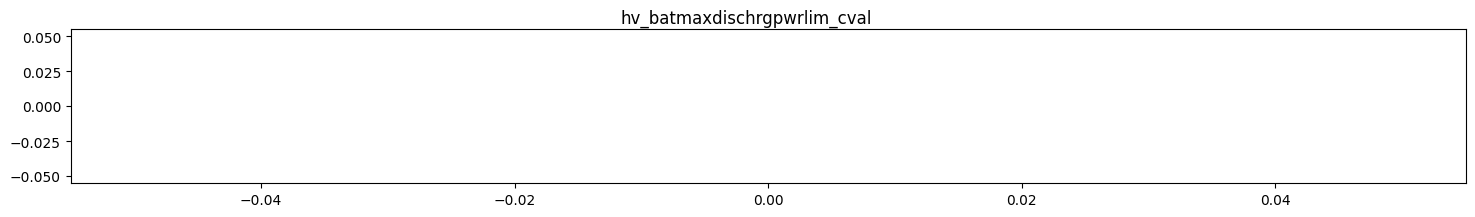

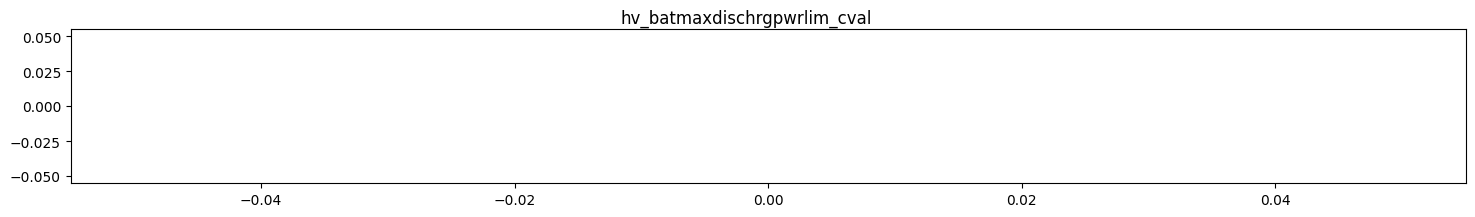

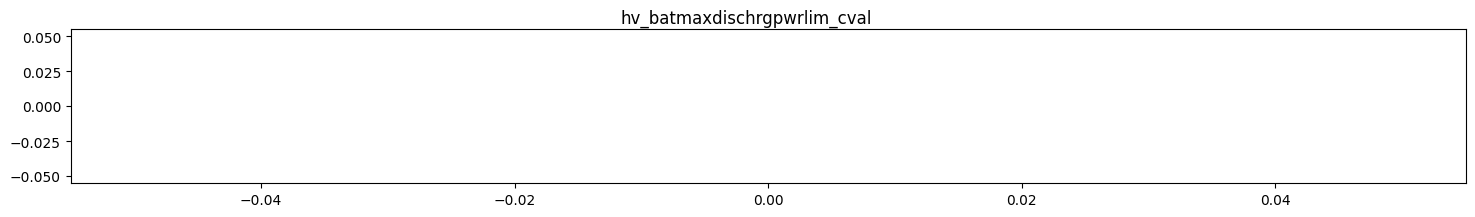

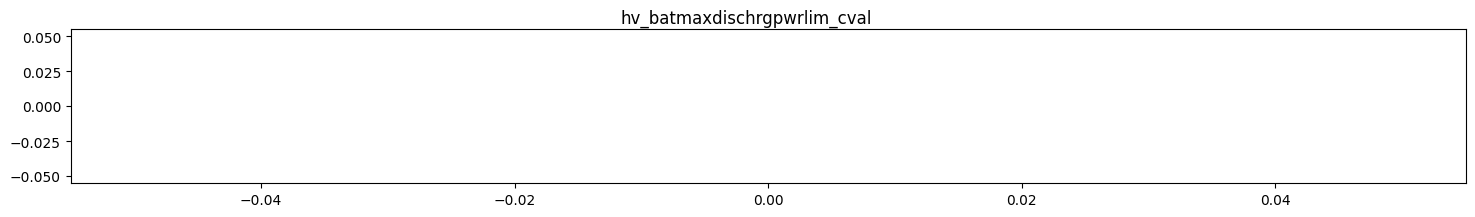

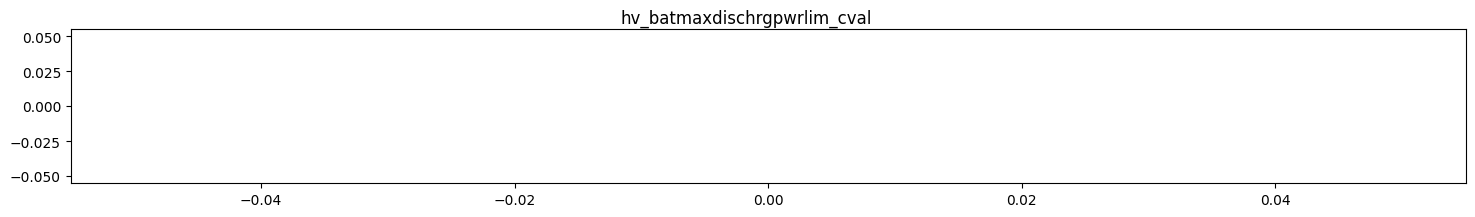

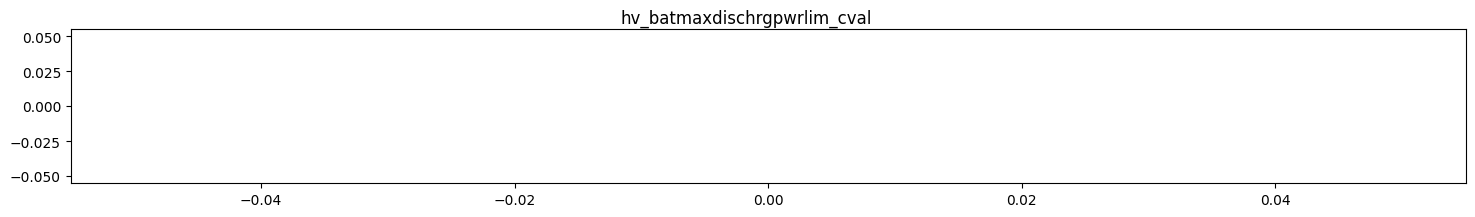

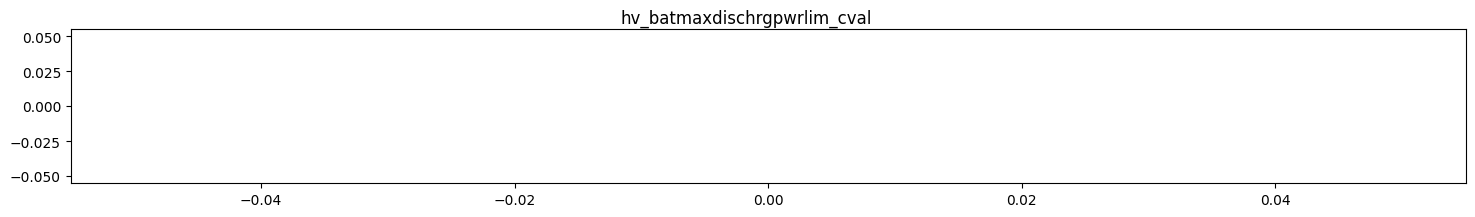

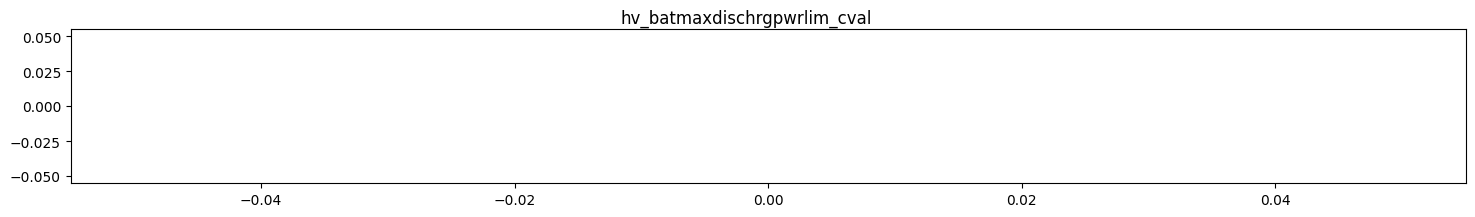

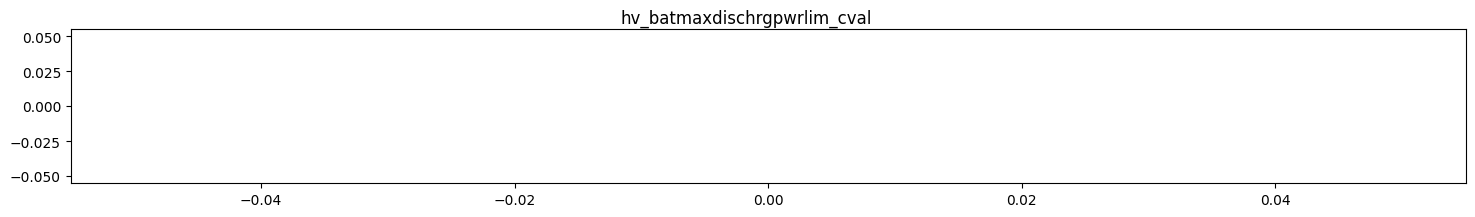

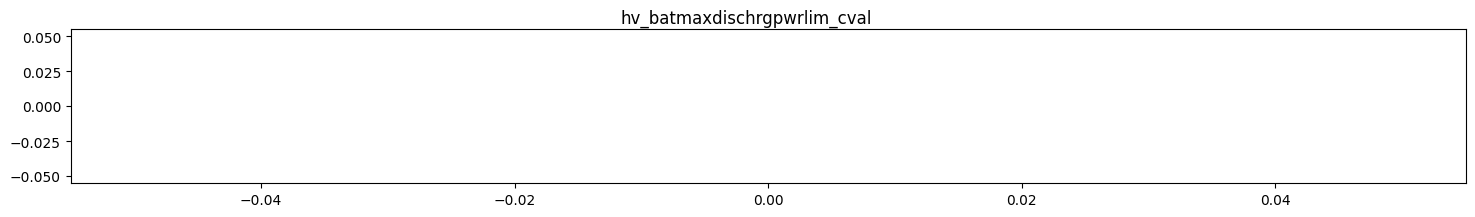

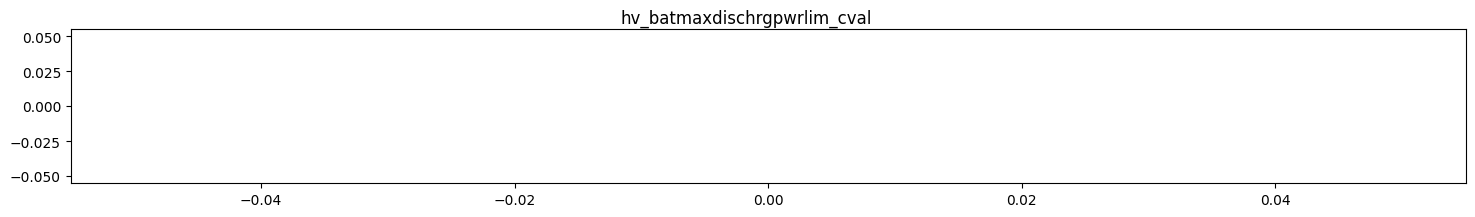

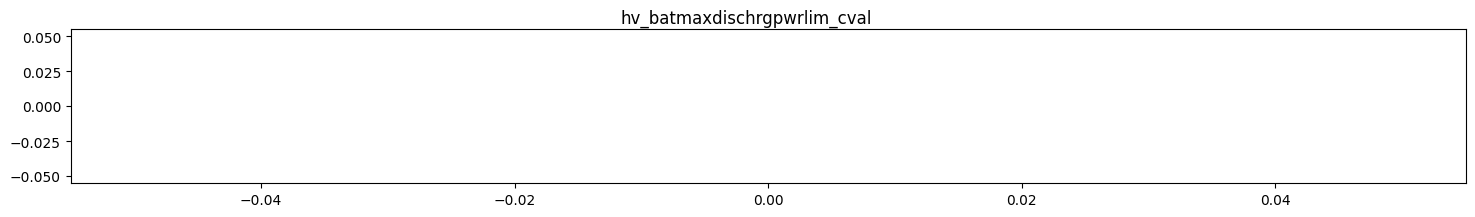

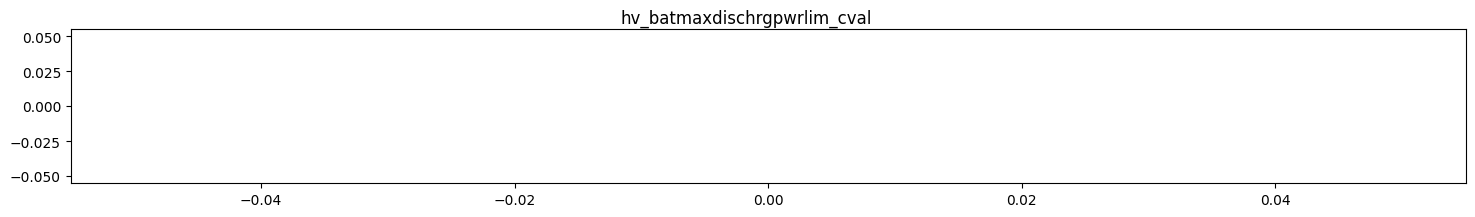

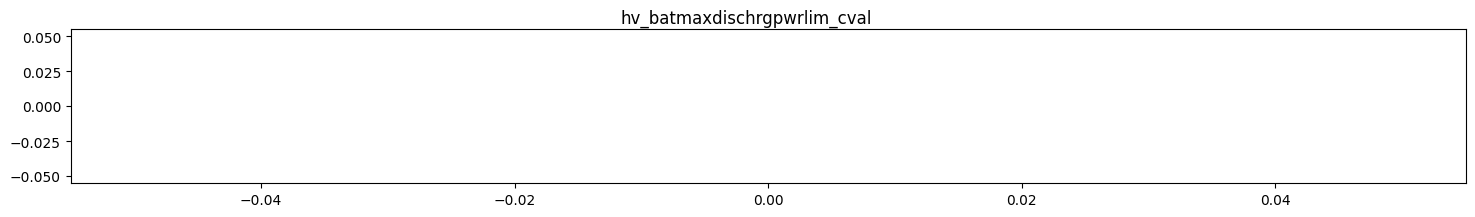

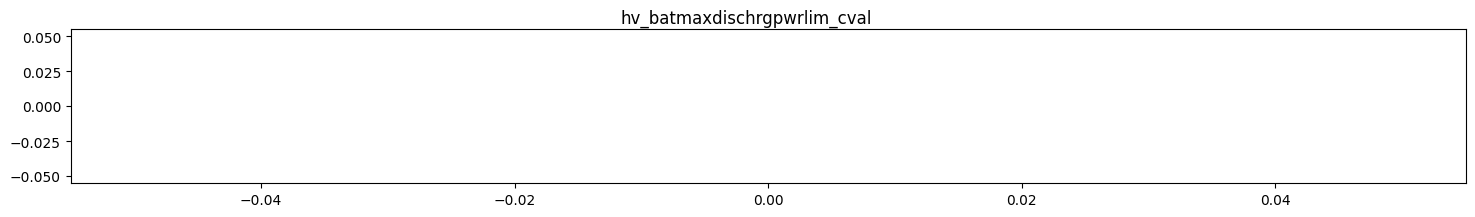

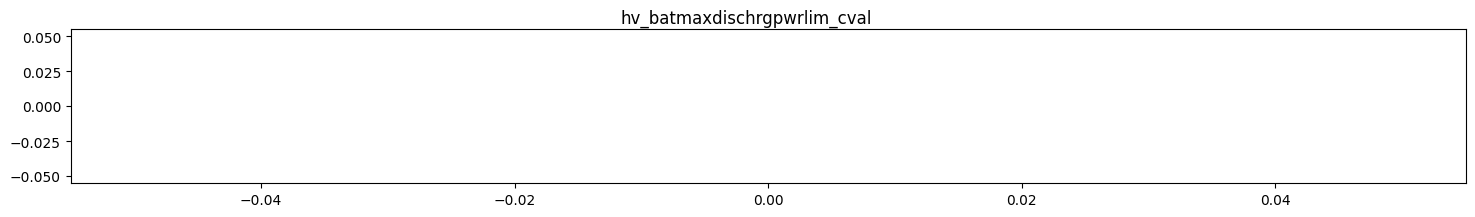

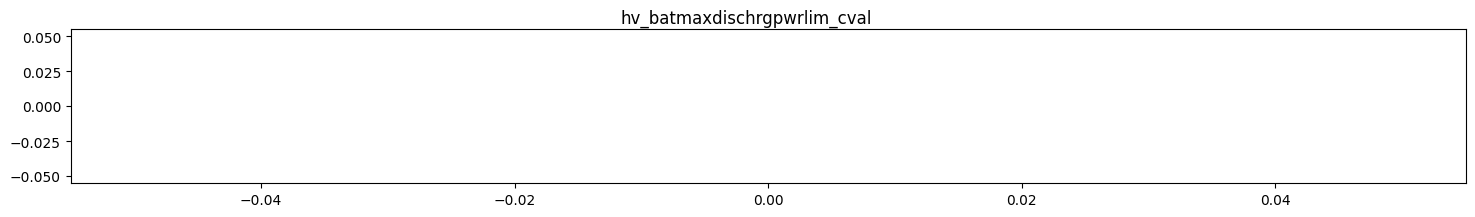

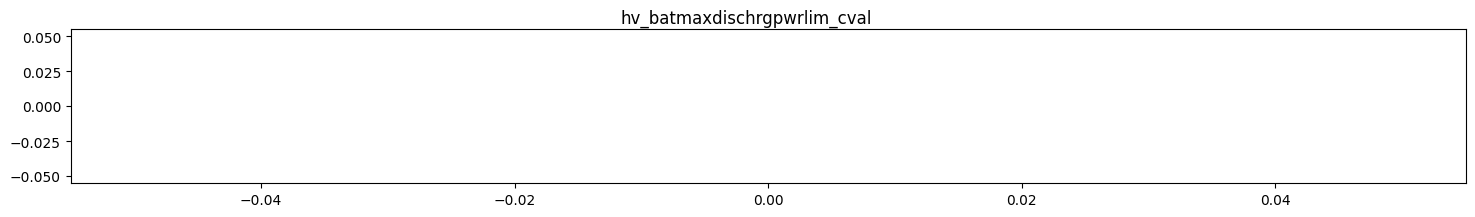

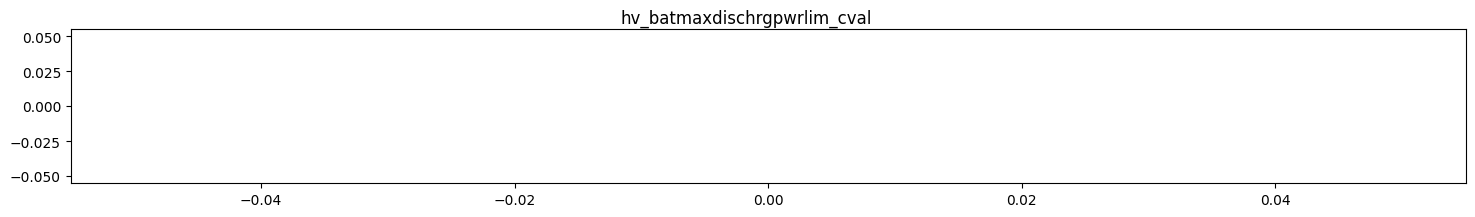

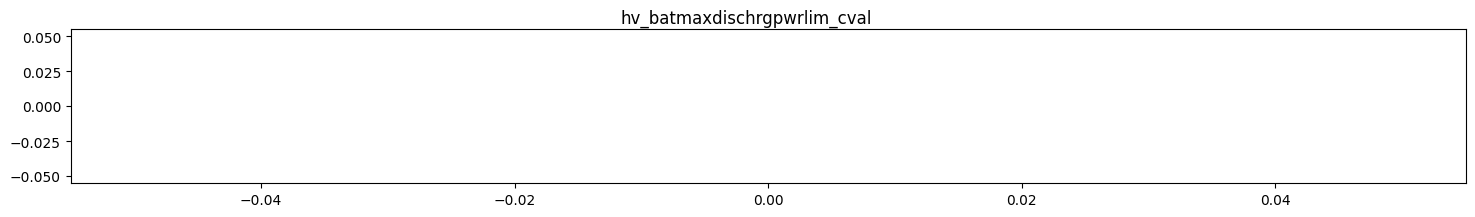

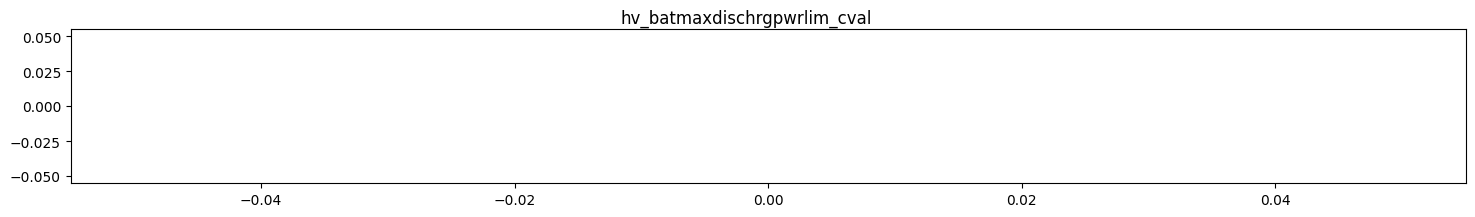

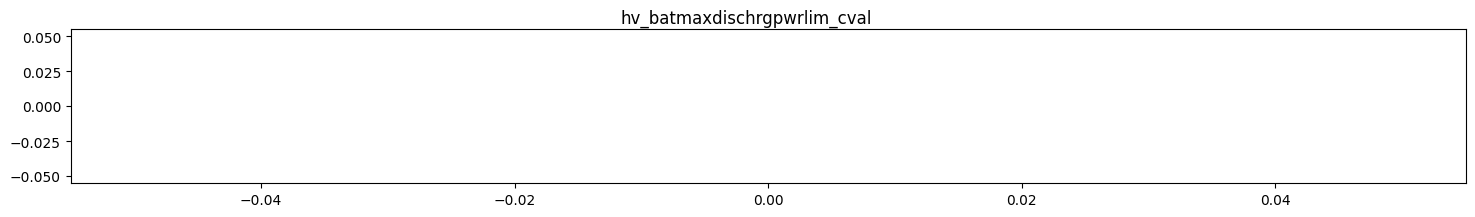

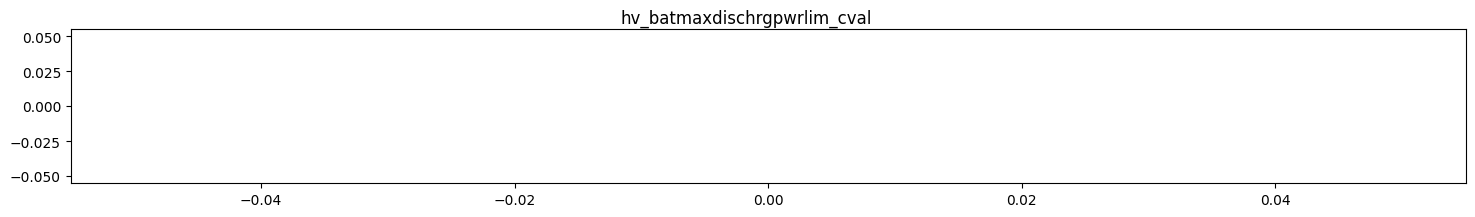

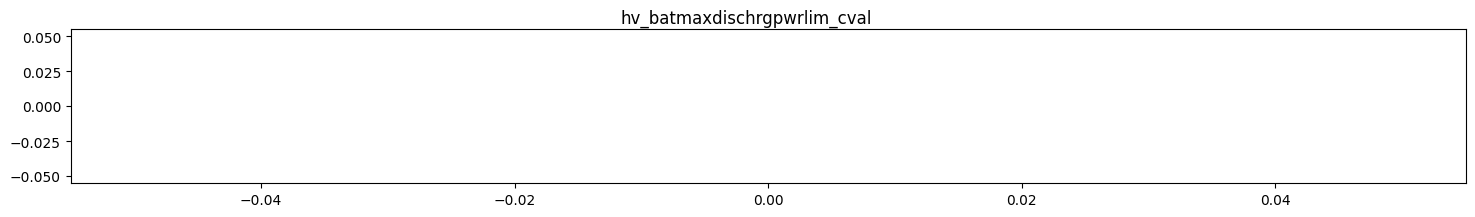

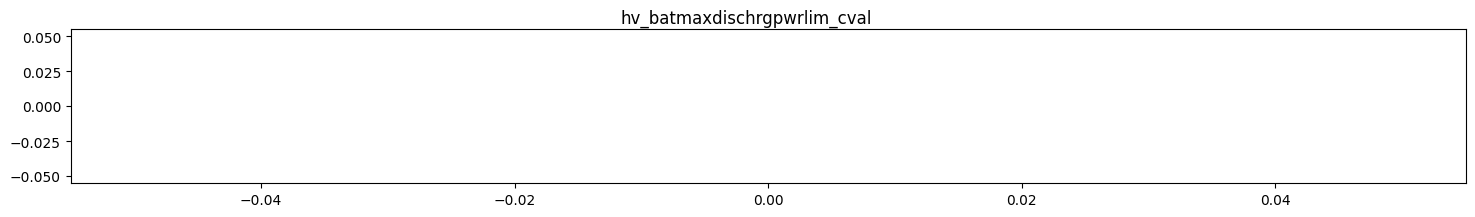

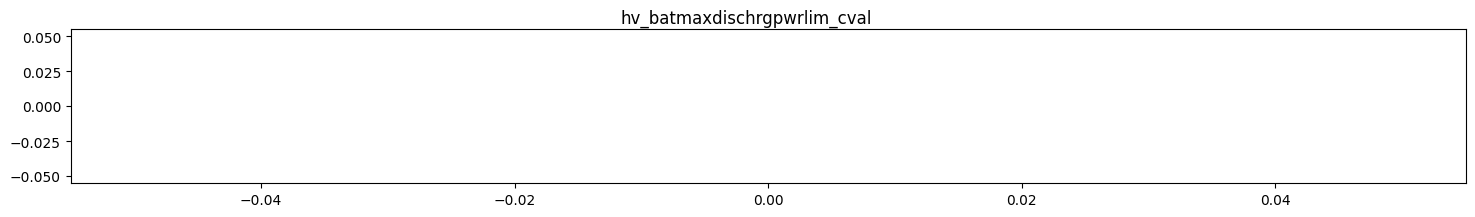

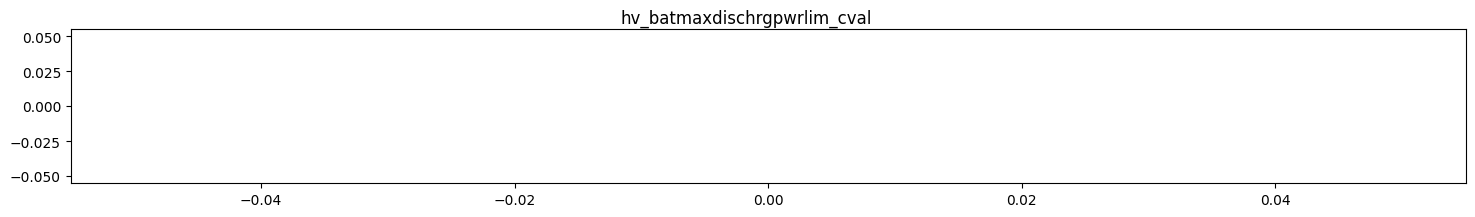

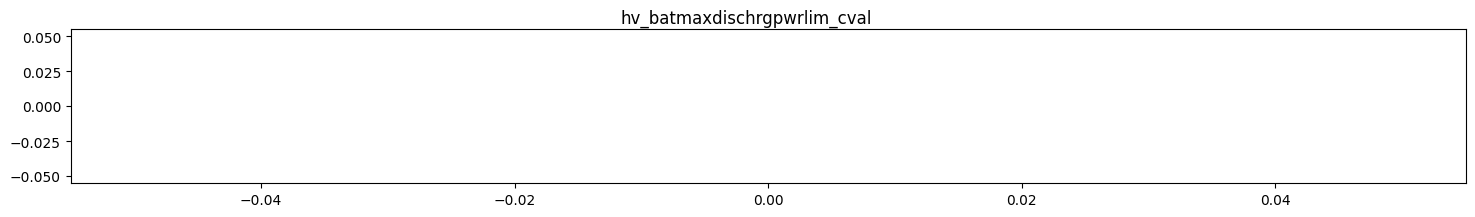

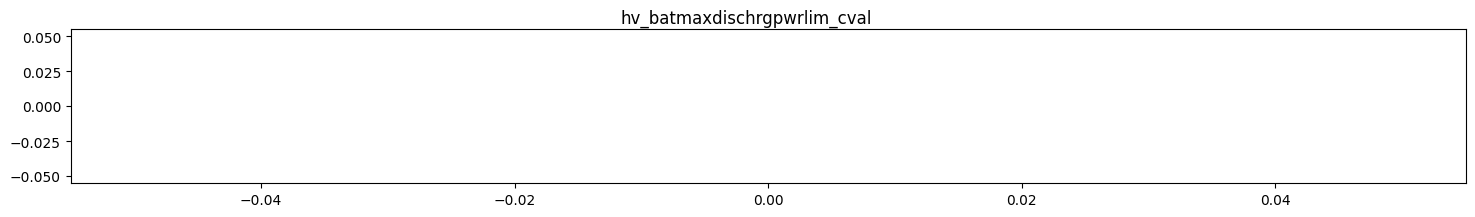

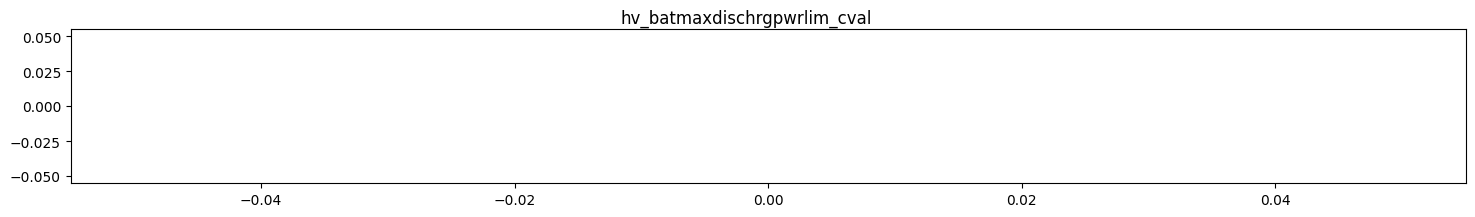

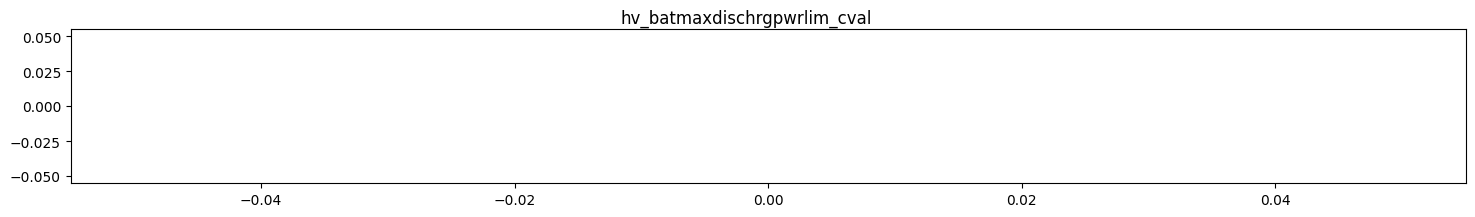

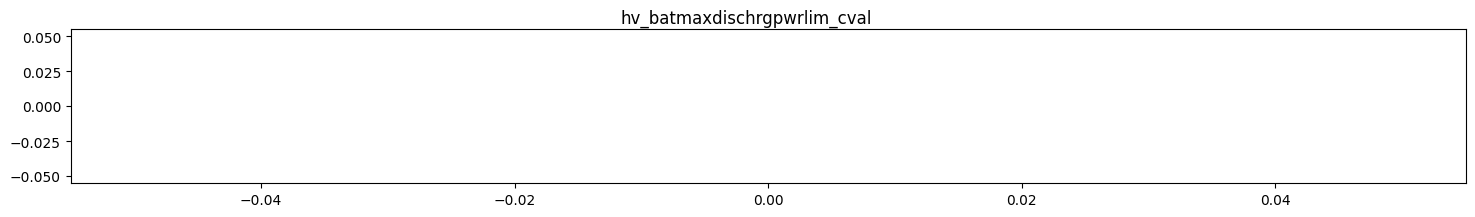

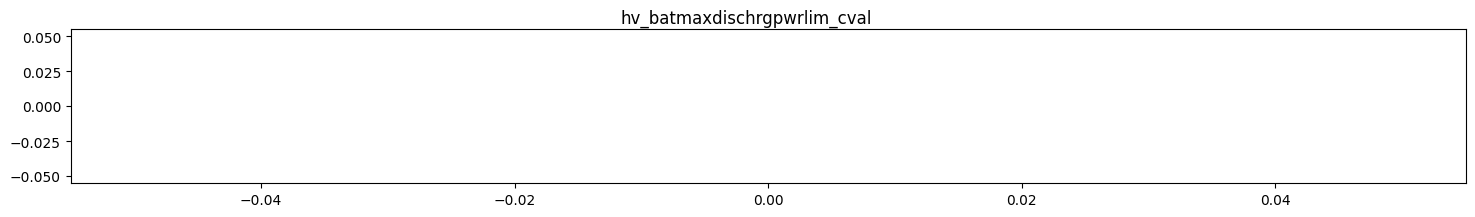

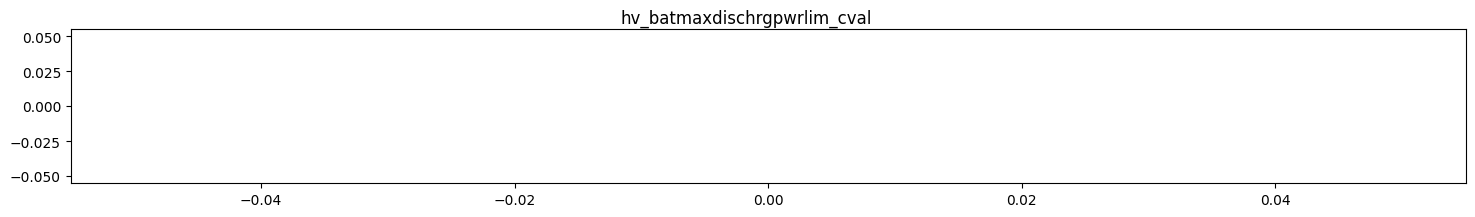

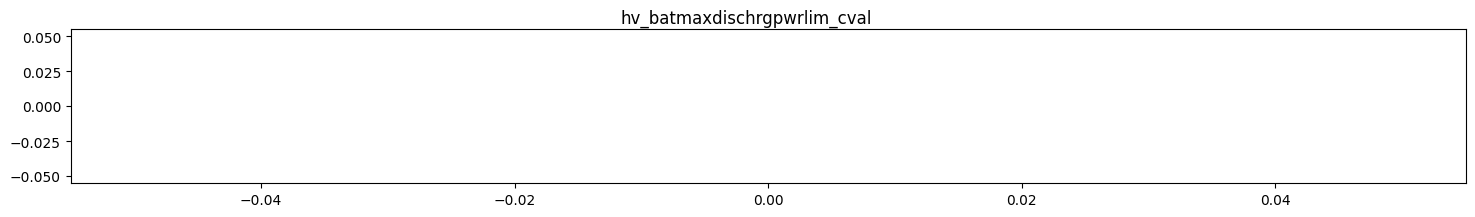

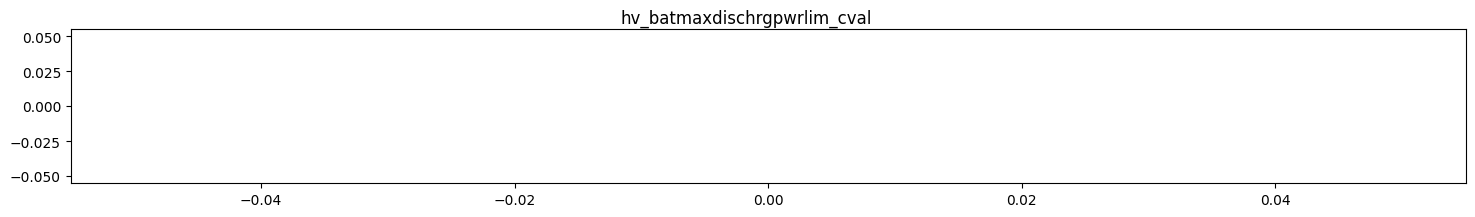

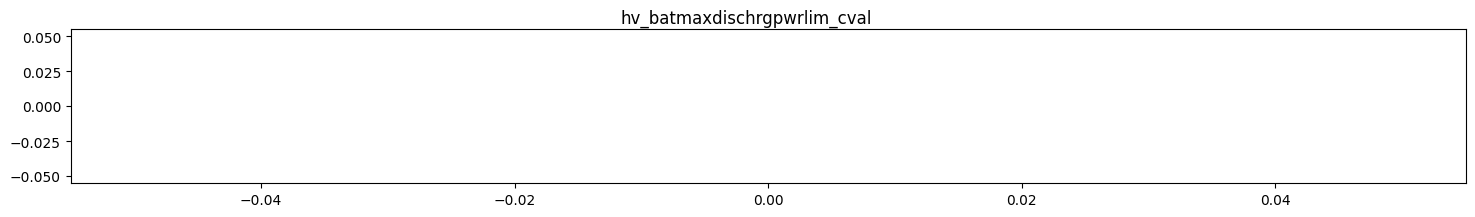

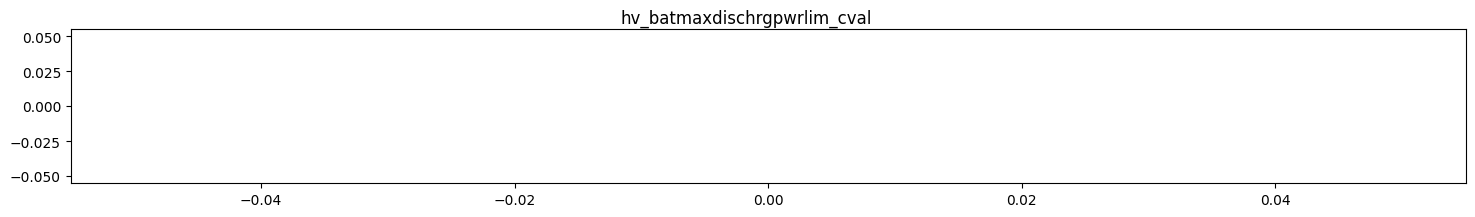

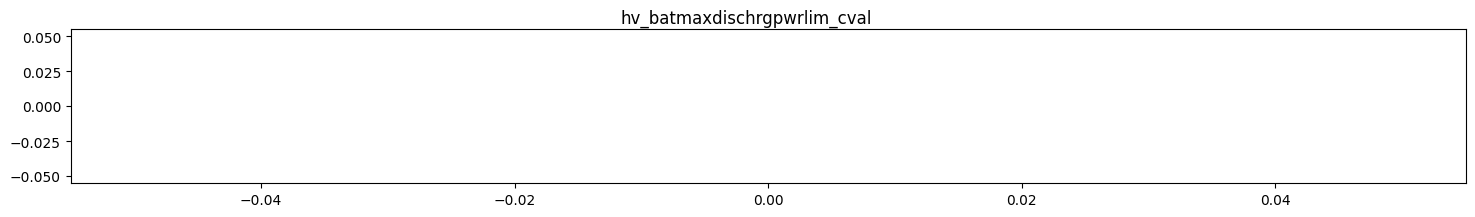

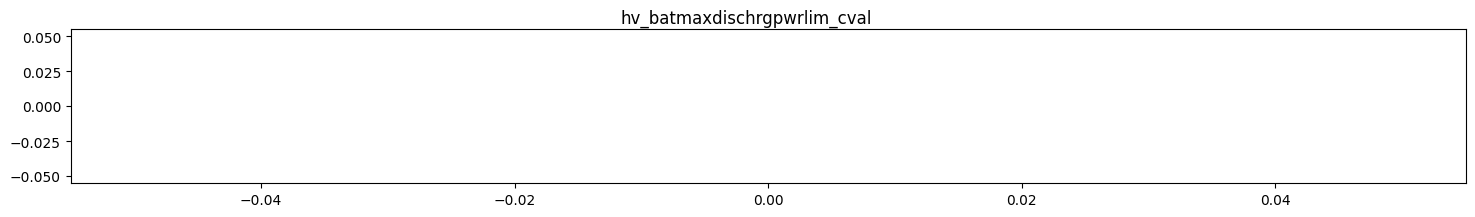

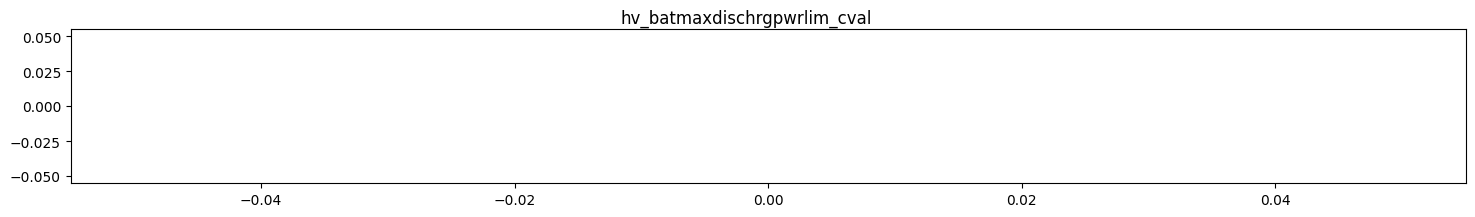

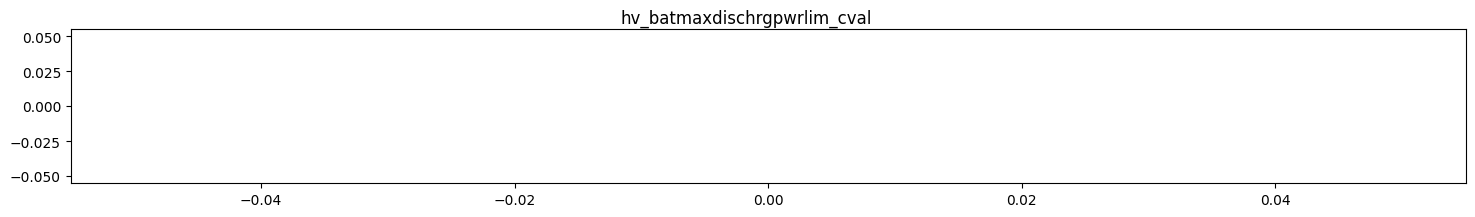

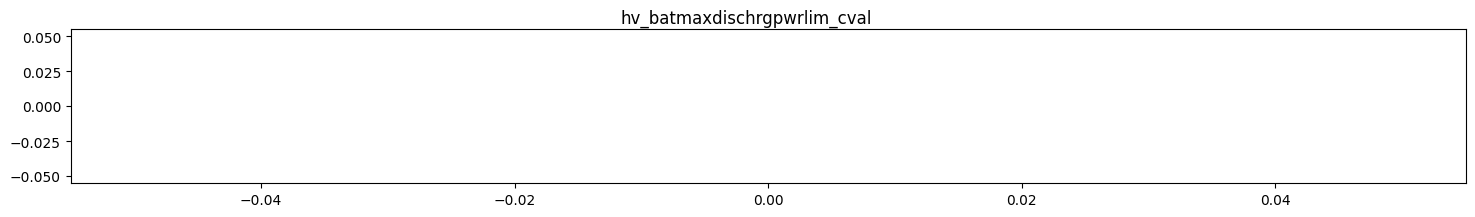

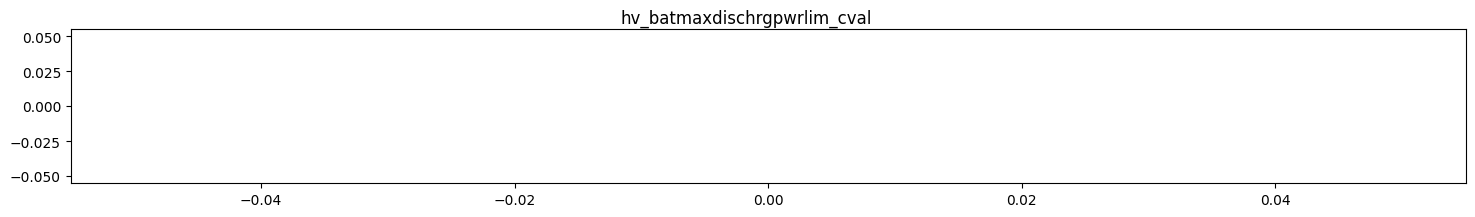

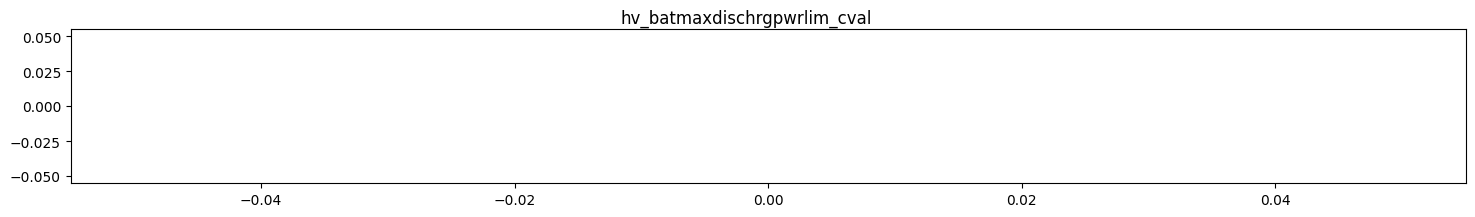

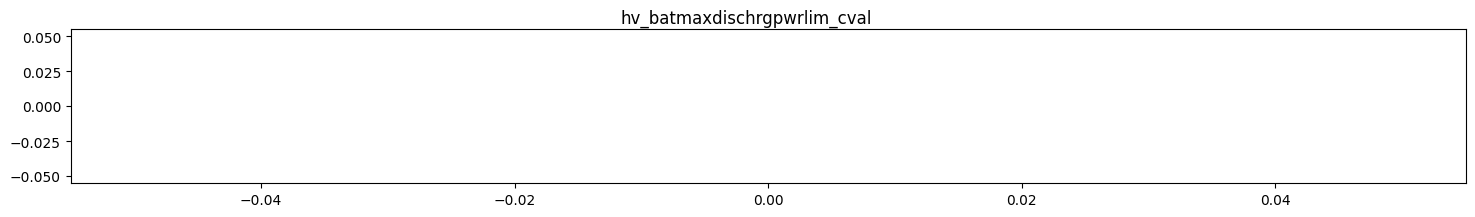

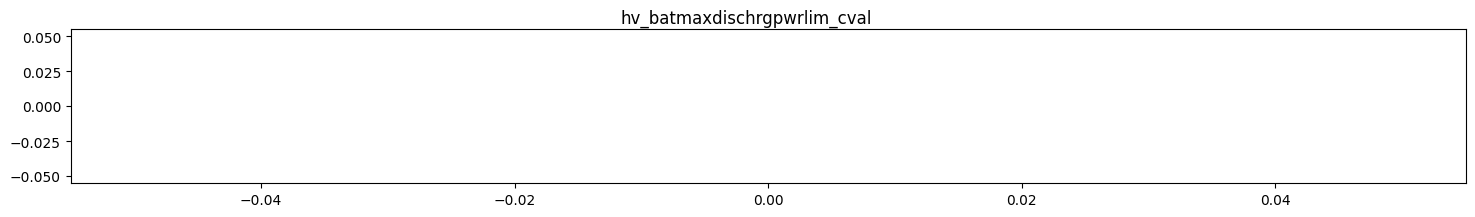

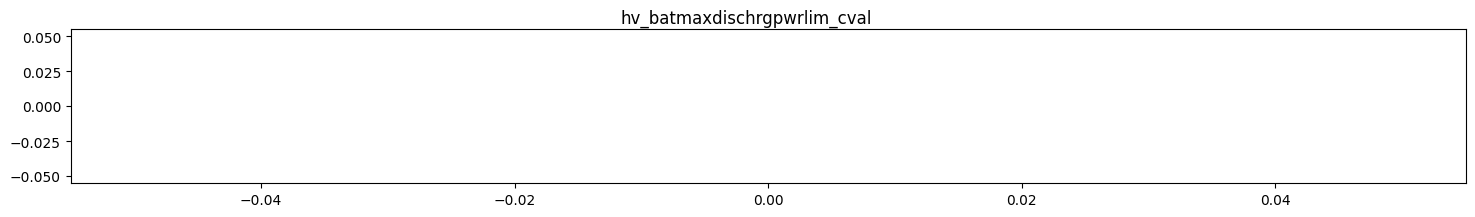

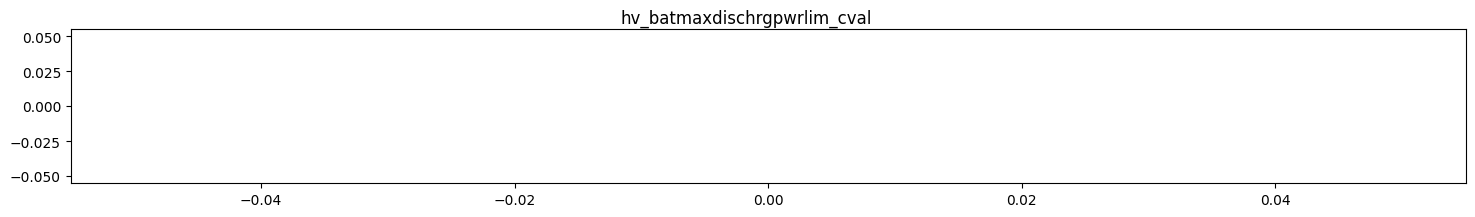

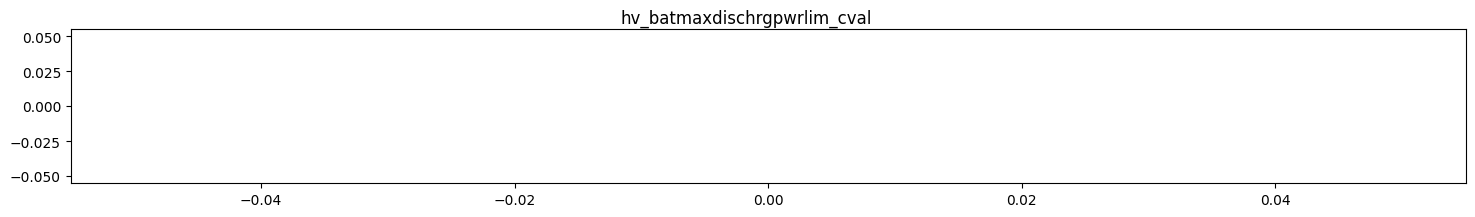

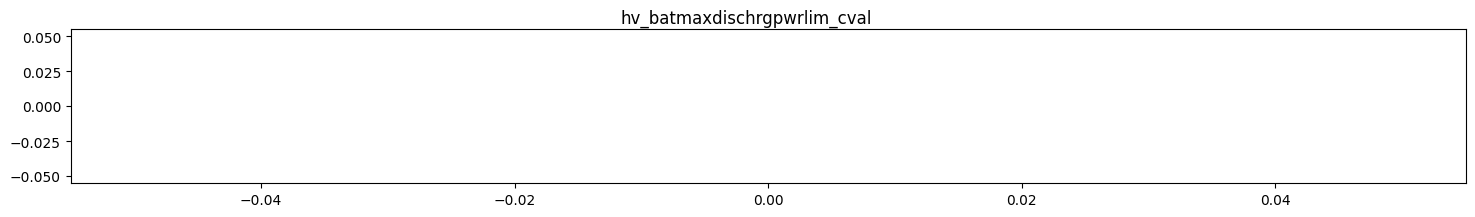

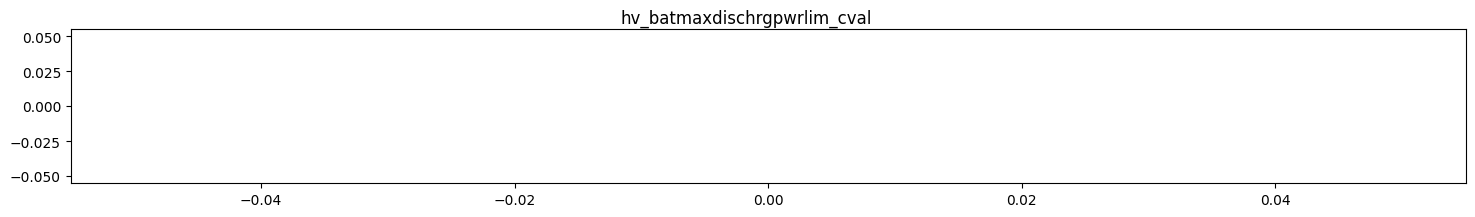

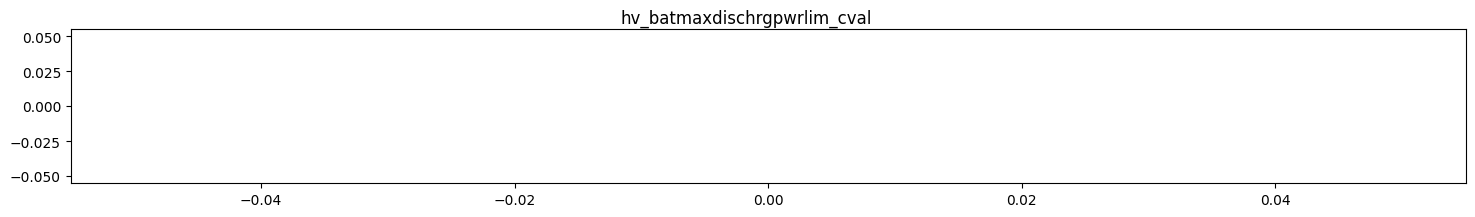

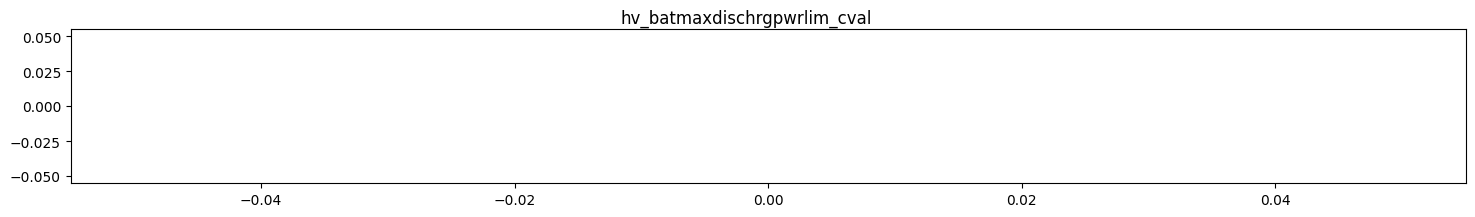

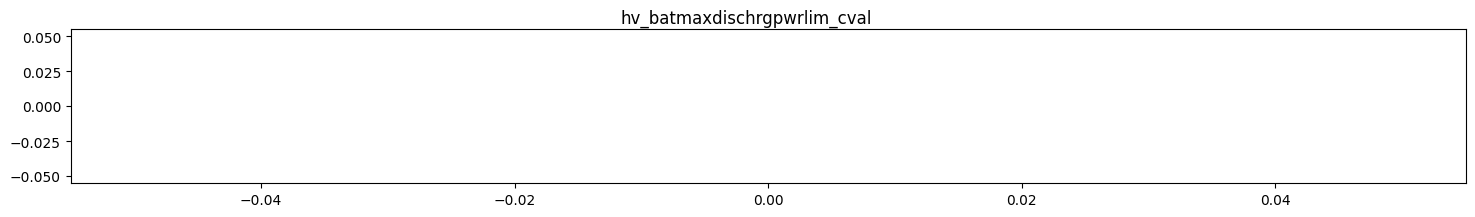

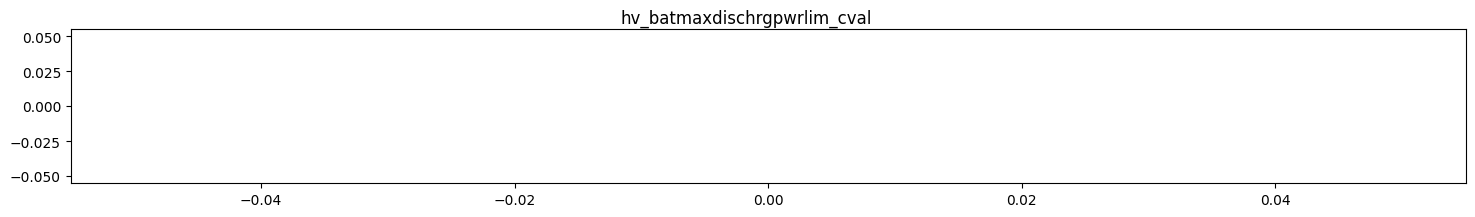

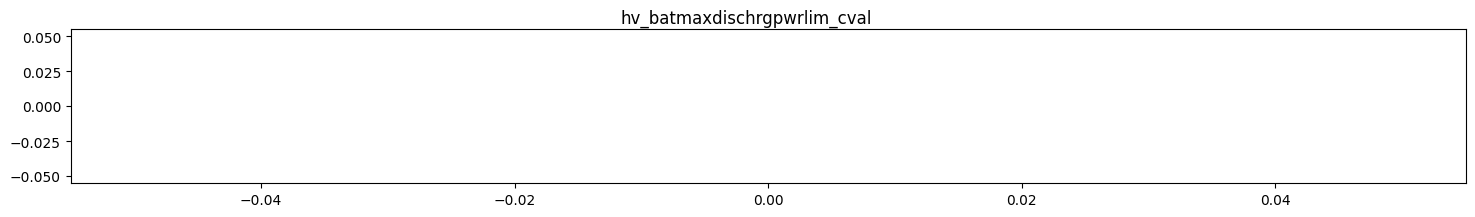

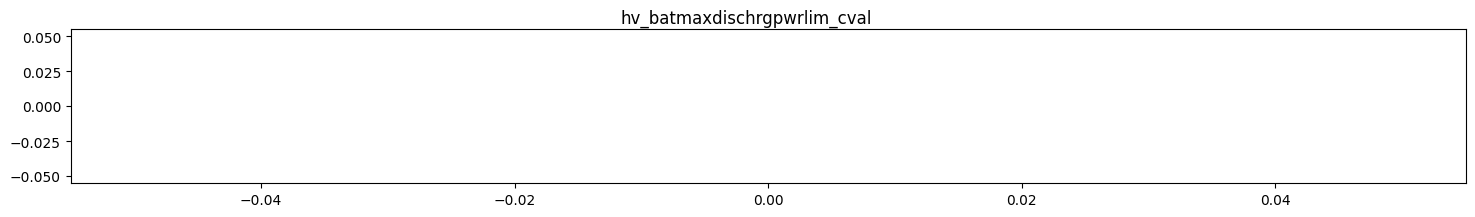

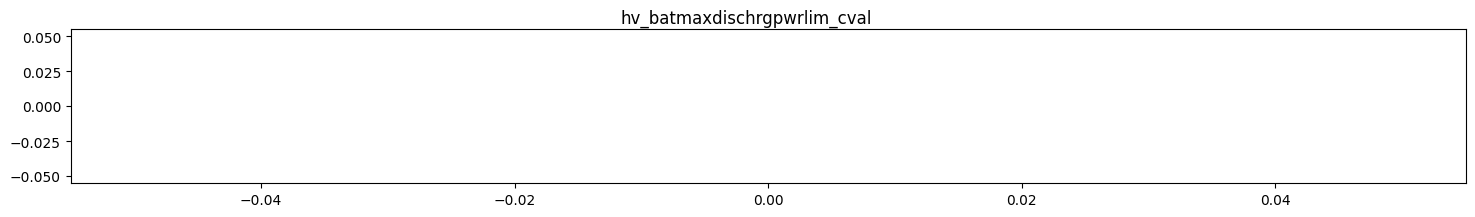

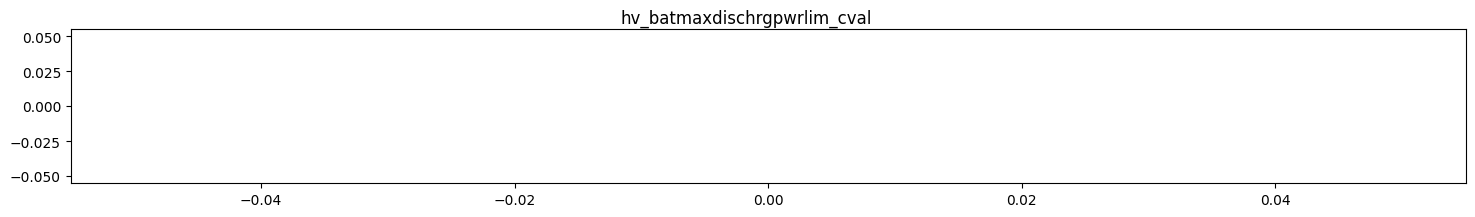

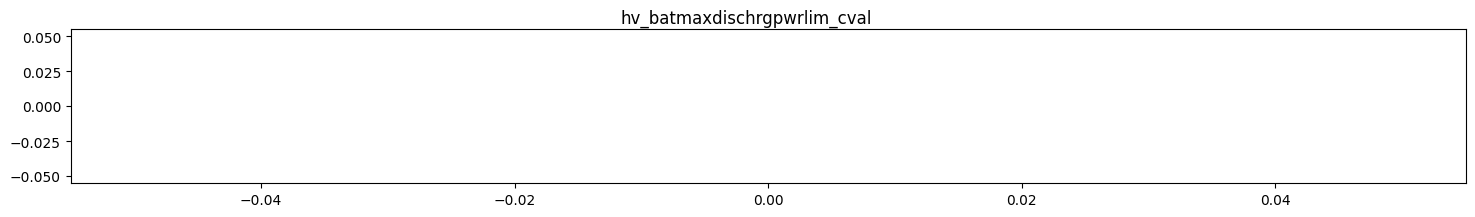

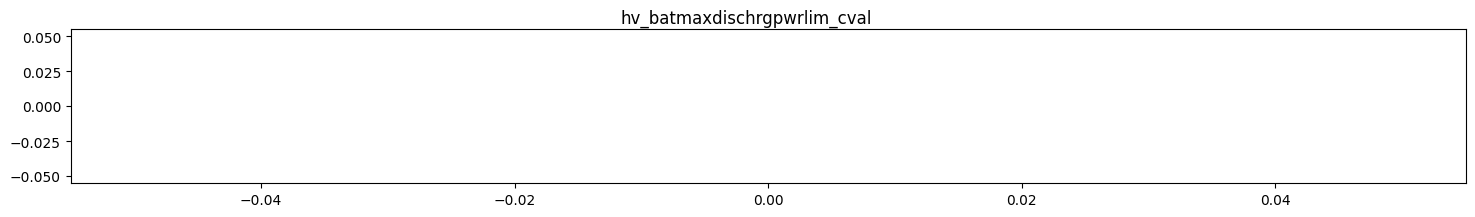

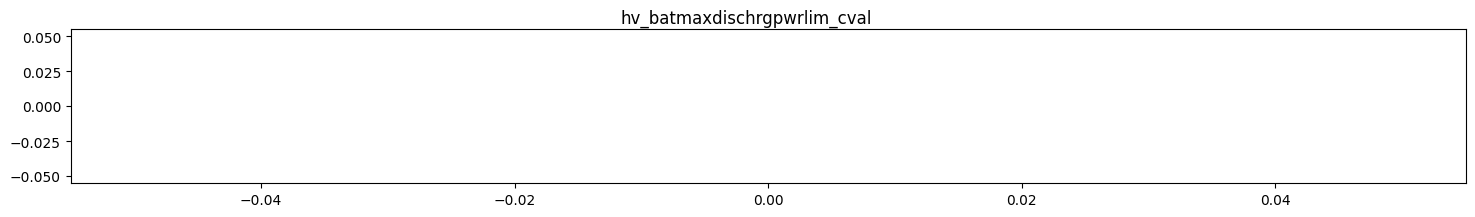

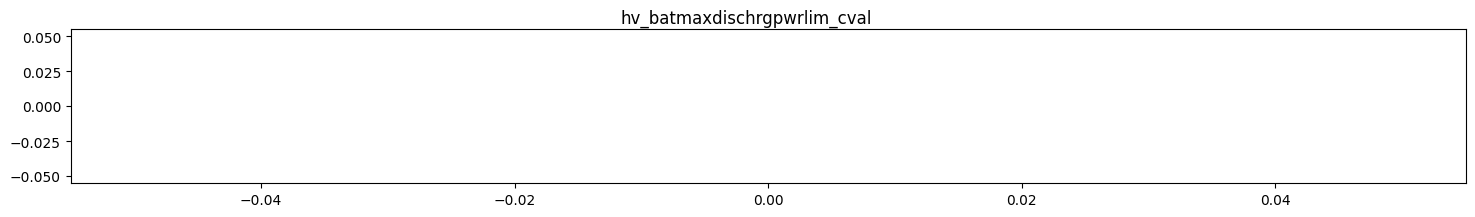

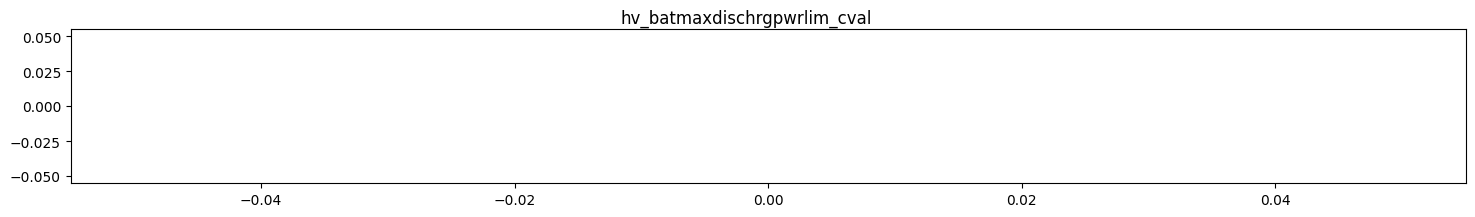

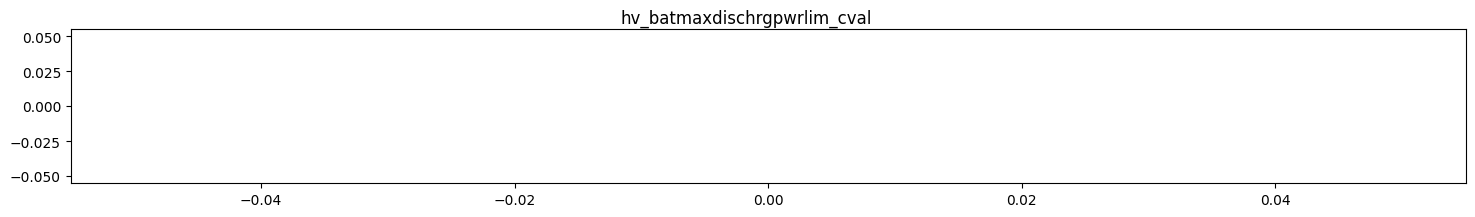

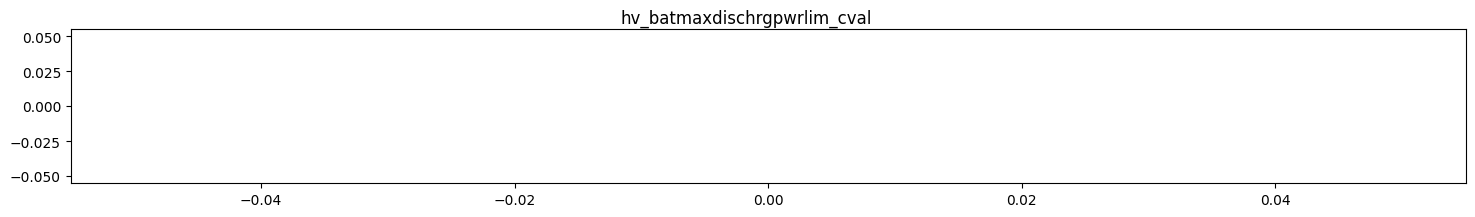

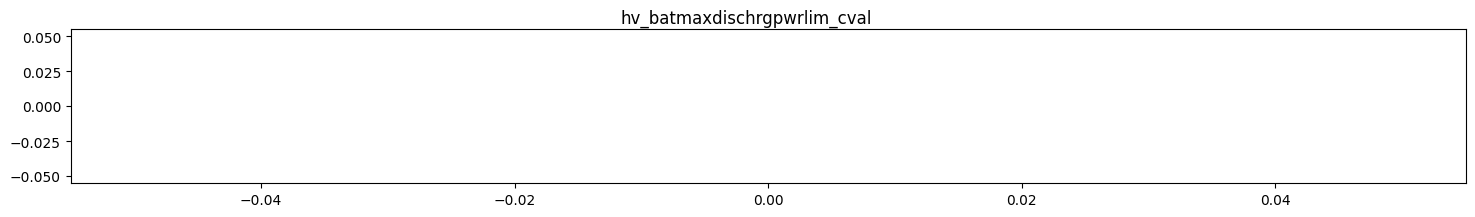

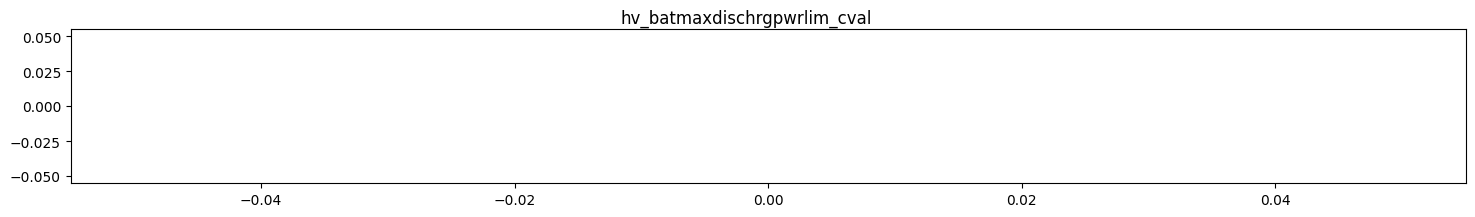

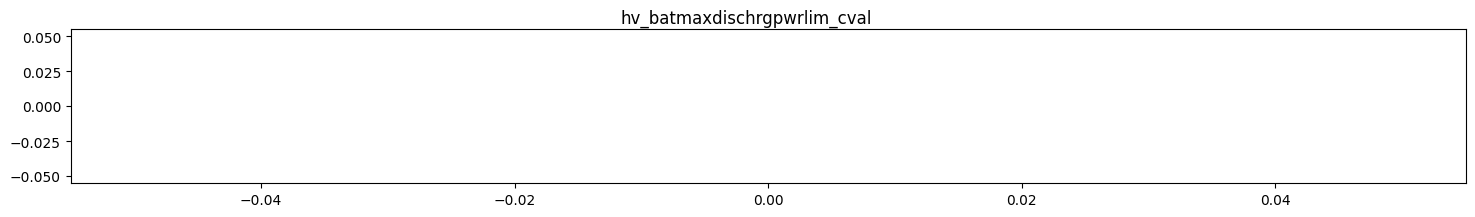

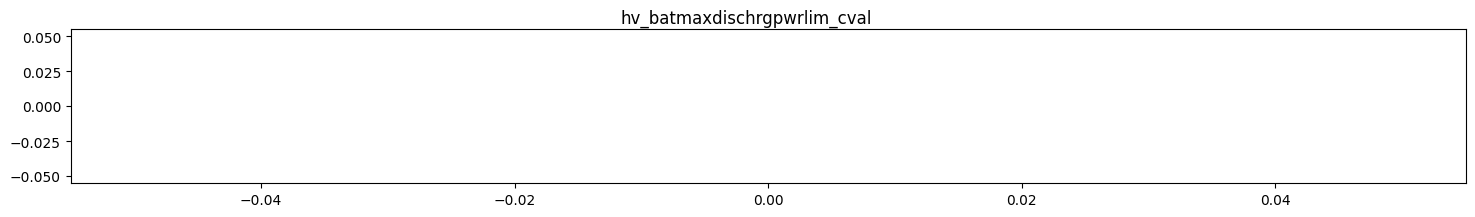

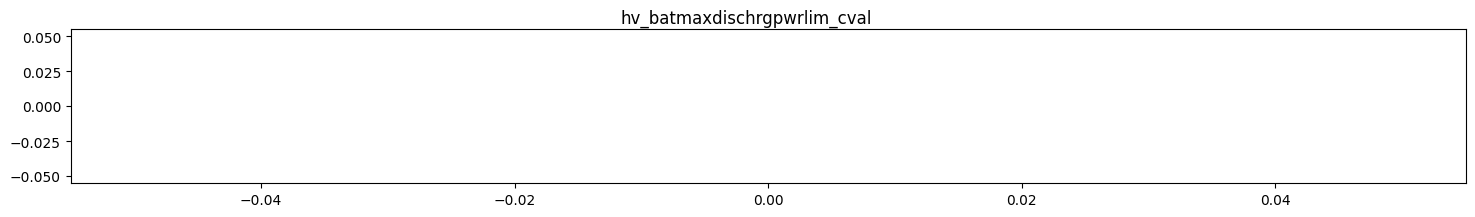

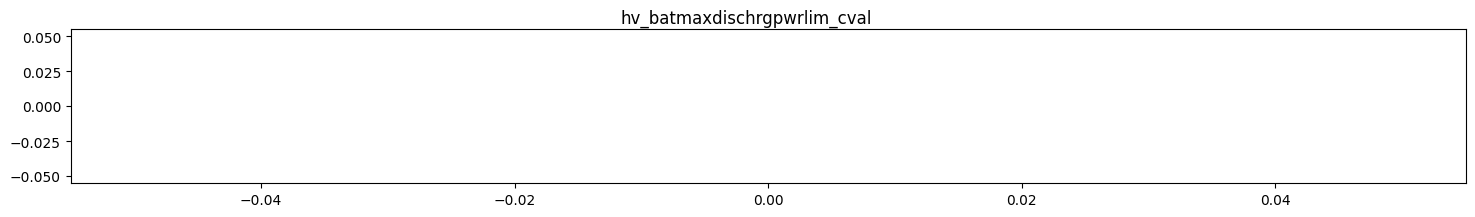

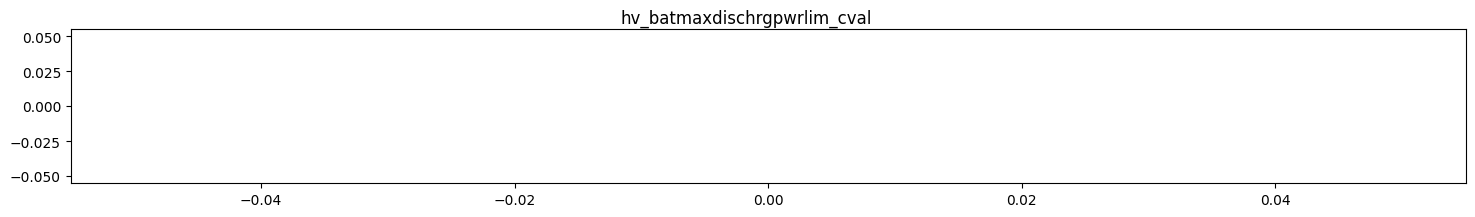

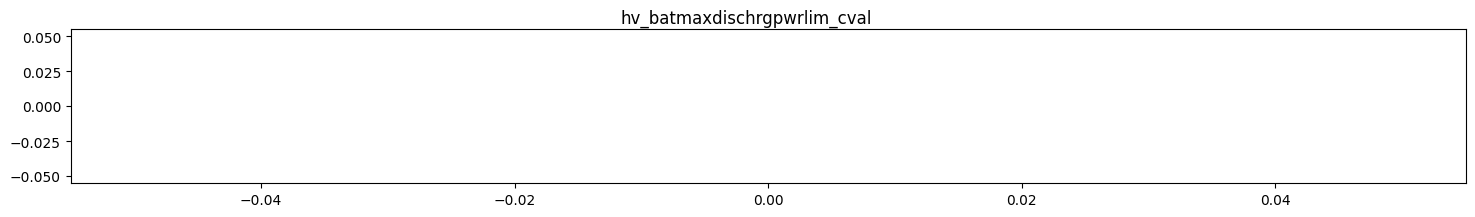

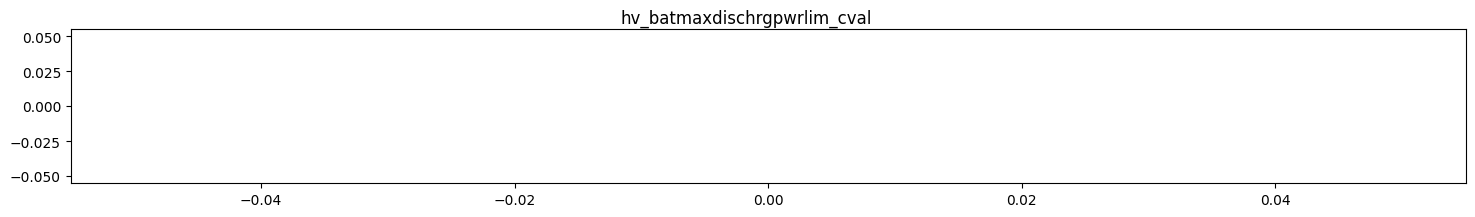

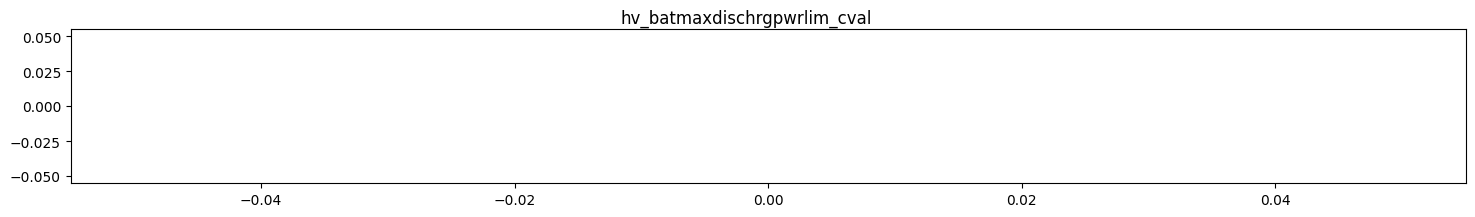

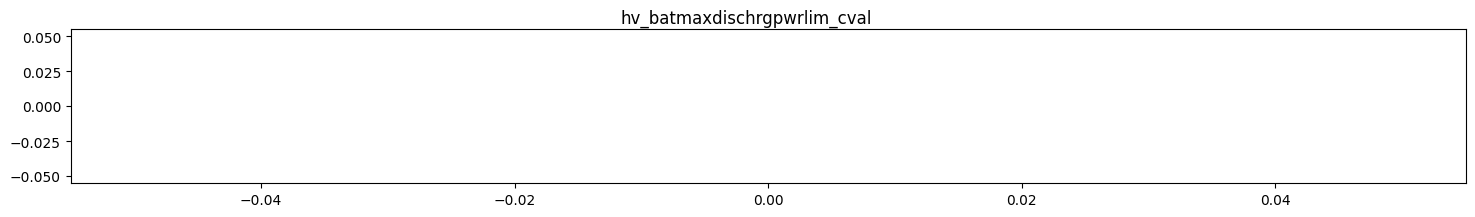

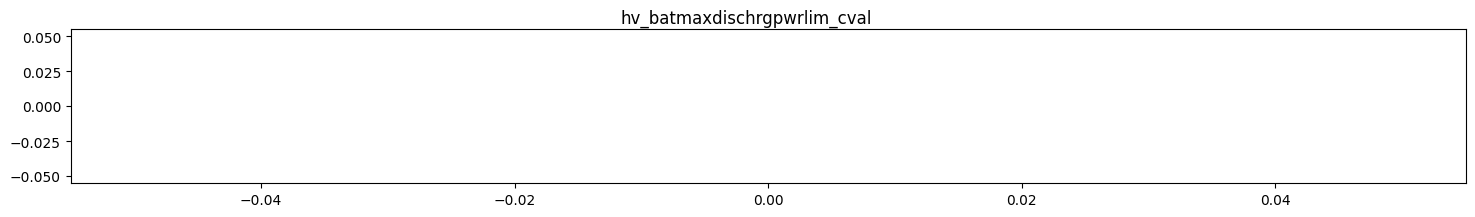

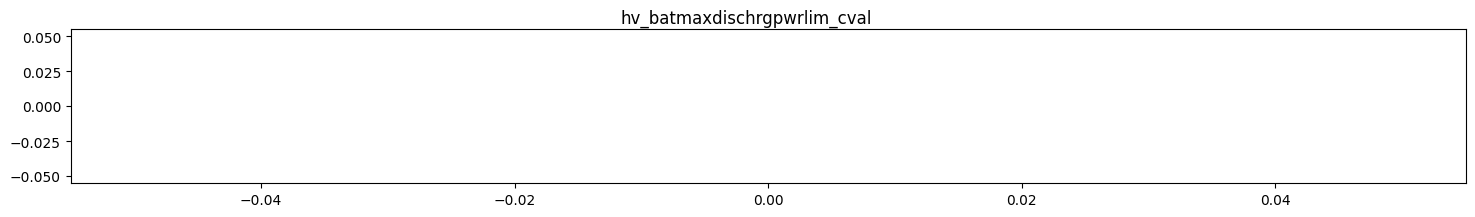

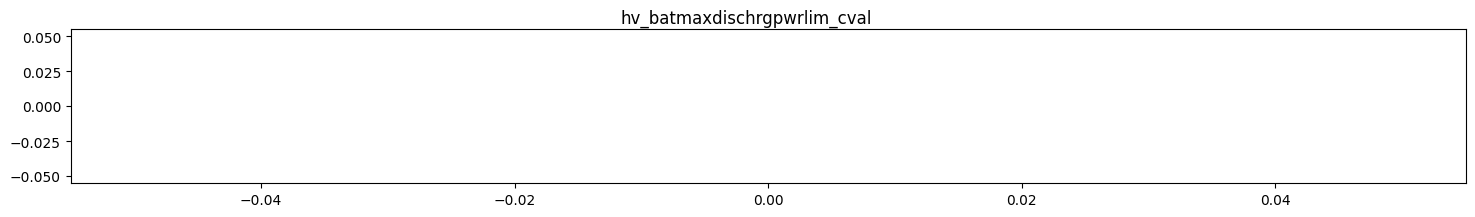

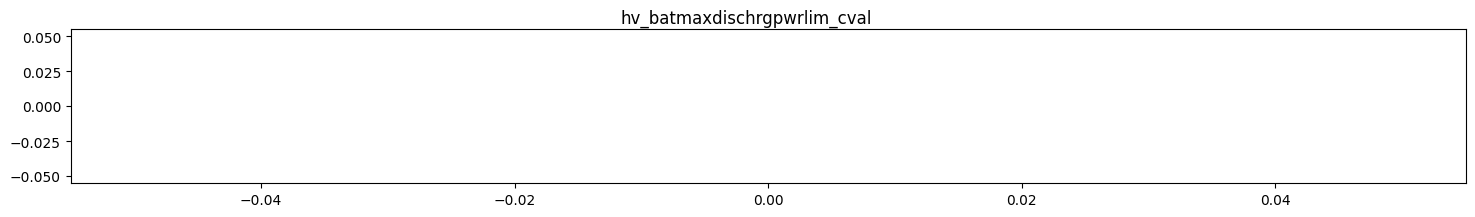

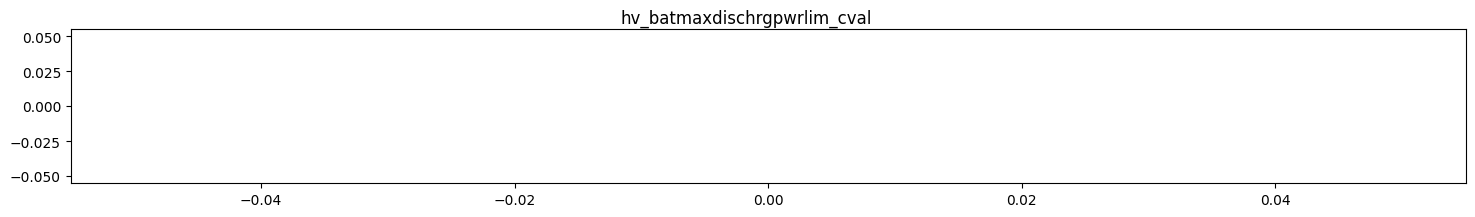

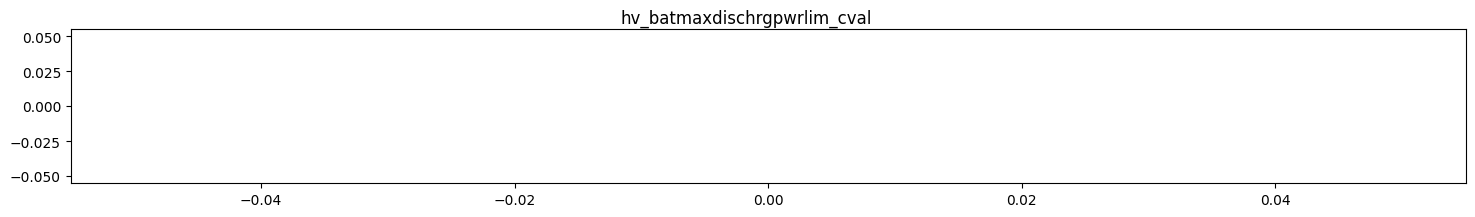

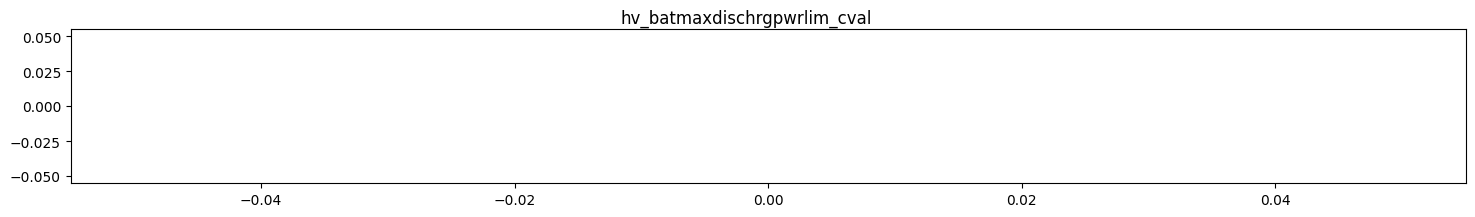

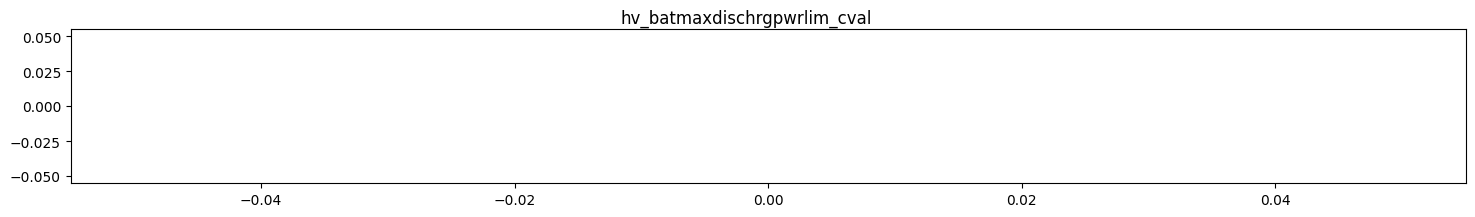

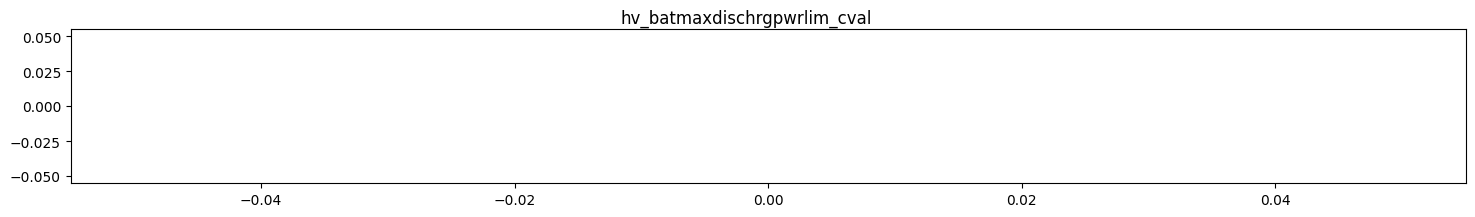

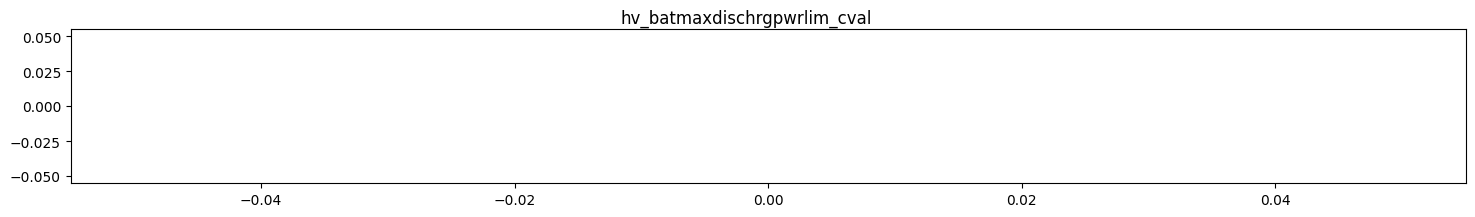

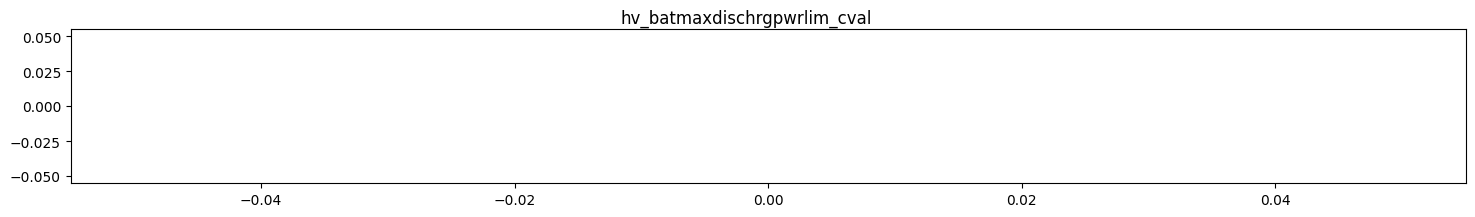

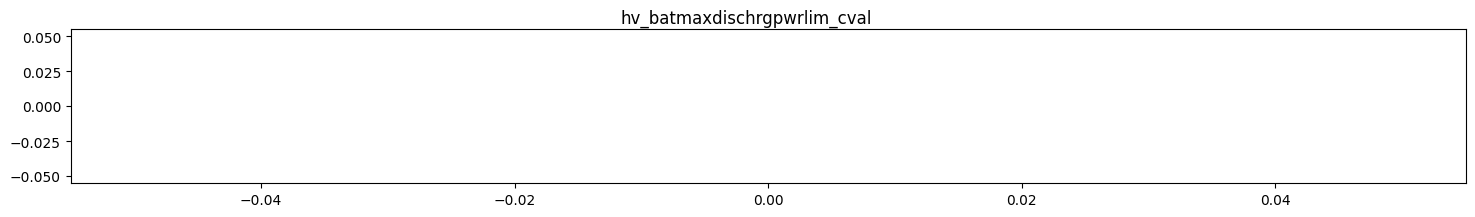

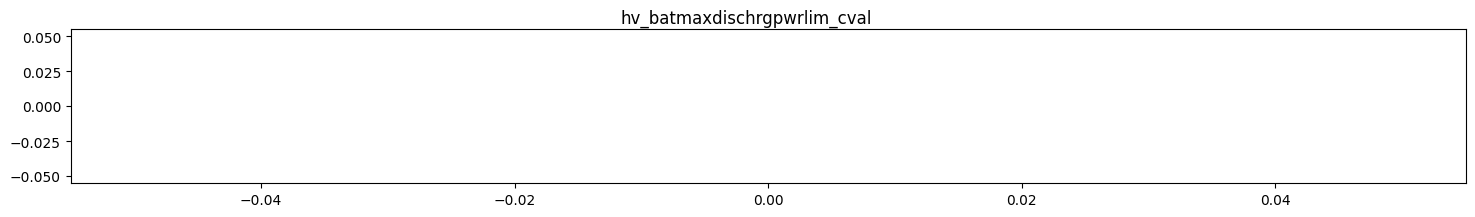

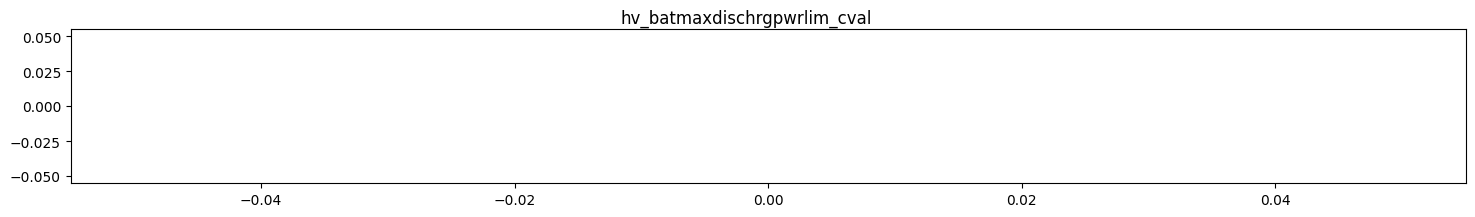

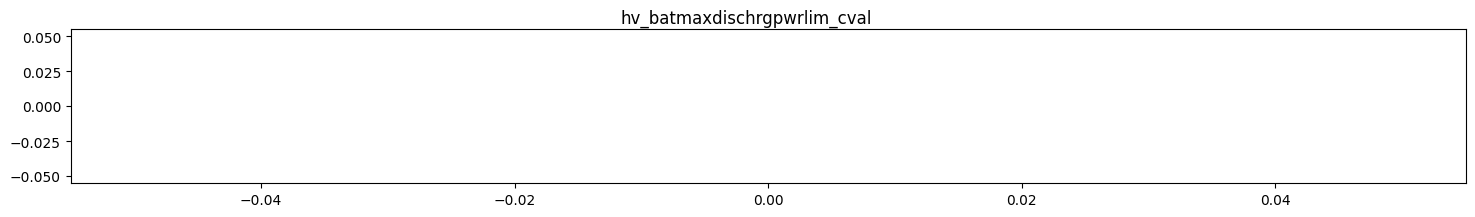

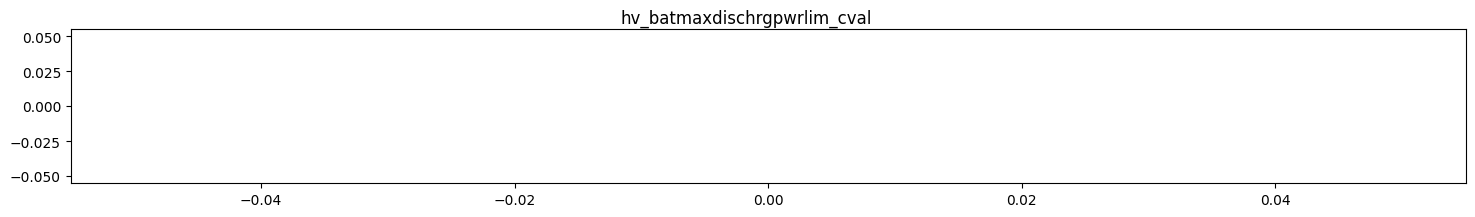

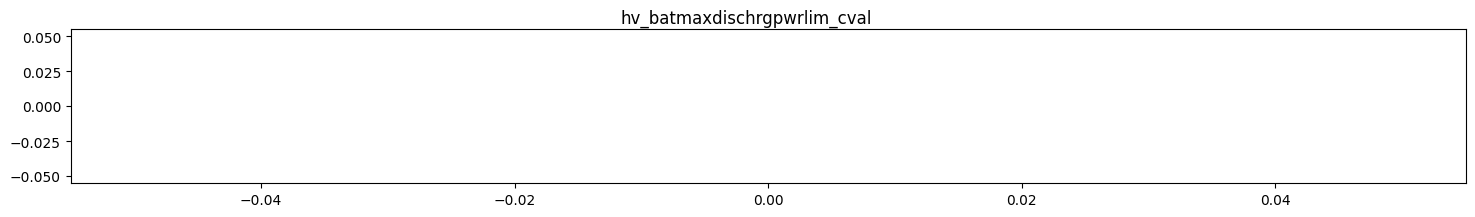

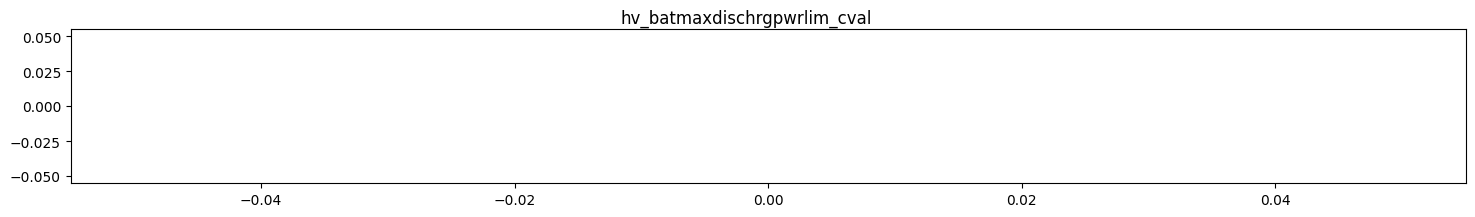

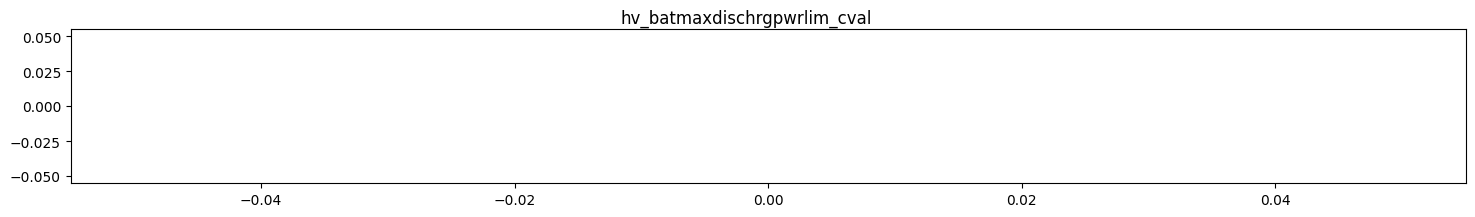

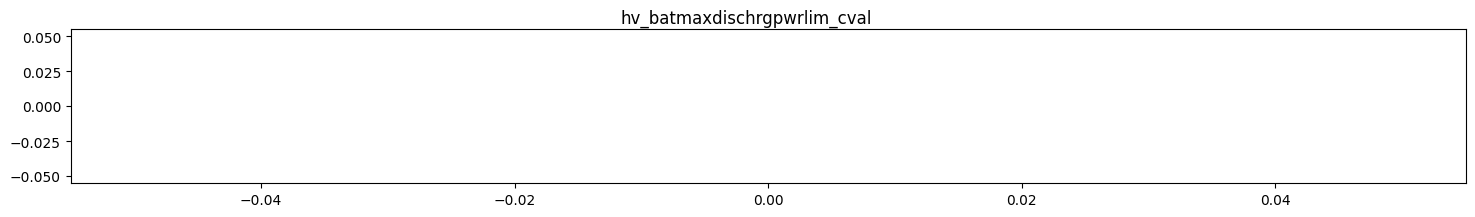

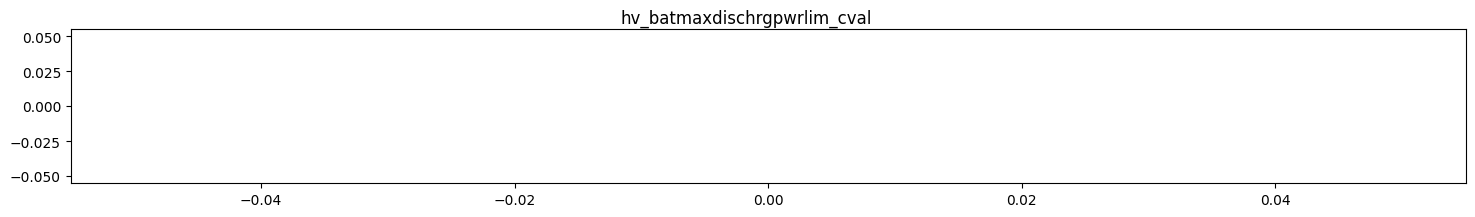

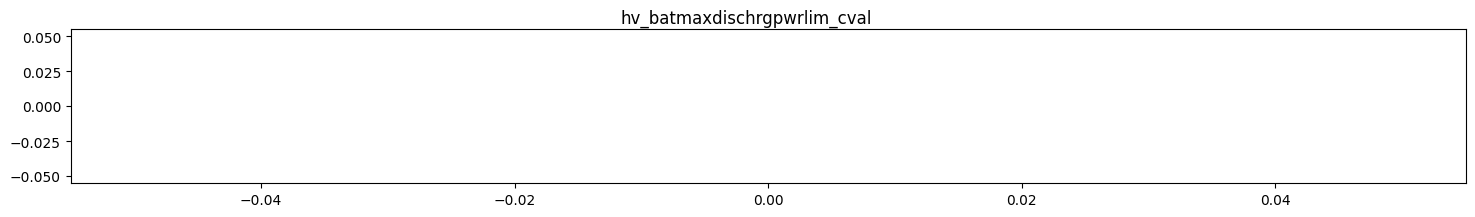

In [ ]:
# plot multiple random time series signals from random files
import matplotlib.pyplot as plt
import random

for sig in ["hv_batmaxdischrgpwrlim_cval"]:
    samples = random.sample(trips, 10)
    for f in samples:
        df = pd.read_parquet(Path(parquet_folder, f), engine='fastparquet')
        _ = df[sig].plot(figsize=(18, 2), subplots=True, title=sig)
       # _ = pd.DataFrame(df["chargestate"]*100).plot(figsize=(18, 5), subplots=True, color='r')
       # _ = df["hv_chrgpwr_ecpc_cval"].plot(figsize=(18, 5), subplots=True, title="hv_chrgpwr_ecpc_cval")
        plt.show()

In [12]:
def check_nans_in_parquet_files(directories):
    files_with_nans = []

    for directory in directories:
        for file in directory.glob("*.parquet"):
            df = pd.read_parquet(file, engine='fastparquet')
            if df.isna().any().any():
                nan_columns = df.columns[df.isna().any()].tolist()
                files_with_nans.append((file, nan_columns))
                print(f"File {file} has NaNs in columns: {nan_columns}")

    return files_with_nans

directories = [Path(DATA_PATH, "final_2", "trips_processed_resampled"), Path(DATA_PATH, "final_2", "trips_processed_final")]
files_with_nans = check_nans_in_parquet_files(directories)

print("Files with NaNs:")
for file in files_with_nans:
    print(file)

Files with NaNs:


In [18]:
total_values_count = 0
trips = get_files(trips_processed_final, ".parquet", full=True)

for trip_file in trips:
    metadata = pq.read_metadata(Path(parquet_folder, trip_file))
    total_values_count += metadata.num_rows * metadata.num_columns

print(f"Total number of values in all trip files: {total_values_count}")
print(f"Average file length: {round(total_values_count / (len(trips) * metadata.num_columns))}")



Total number of values in all trip files: 6380667406
Average file length: 36979


In [ ]:

for trip_file in trips:
    df = pd.read_parquet(Path(parquet_folder, trip_file), engine='fastparquet')

    total_values_count += df.size

print(f"Total number of values in all trip files: {total_values_count}")

In [19]:
import os

base_names = [os.path.basename(file[0]) for file in files_with_nans]
print(base_names)
[f for f in base_names if f not in remove_selection]


['v_id983V101_trip146.parquet', 'v_id983V101_trip24.parquet', 'v_id983V10_trip20.parquet', 'v_id983V10_trip31.parquet', 'v_id983V12_trip107_2.parquet', 'v_id983V13_trip252.parquet', 'v_id983V14_trip283.parquet', 'v_id983V16_trip2.parquet', 'v_id983V17_trip132.parquet', 'v_id983V17_trip14_2.parquet', 'v_id983V17_trip199.parquet', 'v_id983V19_trip103.parquet', 'v_id983V19_trip111.parquet', 'v_id983V19_trip23.parquet', 'v_id983V19_trip92.parquet', 'v_id983V1_trip129.parquet', 'v_id983V1_trip13.parquet', 'v_id983V1_trip17.parquet', 'v_id983V1_trip180_2.parquet', 'v_id983V1_trip24.parquet', 'v_id983V1_trip55.parquet', 'v_id983V1_trip57.parquet', 'v_id983V4_trip29.parquet', 'v_id983V4_trip58.parquet', 'v_id983V4_trip72.parquet', 'v_id983V101_trip146.parquet', 'v_id983V101_trip24.parquet', 'v_id983V10_trip20.parquet', 'v_id983V10_trip31.parquet', 'v_id983V12_trip107_2.parquet', 'v_id983V13_trip252.parquet', 'v_id983V14_trip283.parquet', 'v_id983V16_trip2.parquet', 'v_id983V17_trip132.parquet'

['v_id983V101_trip146.parquet',
 'v_id983V101_trip24.parquet',
 'v_id983V10_trip20.parquet',
 'v_id983V10_trip31.parquet',
 'v_id983V12_trip107_2.parquet',
 'v_id983V13_trip252.parquet',
 'v_id983V14_trip283.parquet',
 'v_id983V16_trip2.parquet',
 'v_id983V17_trip132.parquet',
 'v_id983V17_trip14_2.parquet',
 'v_id983V17_trip199.parquet',
 'v_id983V19_trip103.parquet',
 'v_id983V19_trip111.parquet',
 'v_id983V19_trip23.parquet',
 'v_id983V19_trip92.parquet',
 'v_id983V1_trip129.parquet',
 'v_id983V1_trip13.parquet',
 'v_id983V1_trip17.parquet',
 'v_id983V1_trip180_2.parquet',
 'v_id983V1_trip24.parquet',
 'v_id983V1_trip55.parquet',
 'v_id983V1_trip57.parquet',
 'v_id983V4_trip29.parquet',
 'v_id983V4_trip58.parquet',
 'v_id983V4_trip72.parquet',
 'v_id983V101_trip146.parquet',
 'v_id983V101_trip24.parquet',
 'v_id983V10_trip20.parquet',
 'v_id983V10_trip31.parquet',
 'v_id983V12_trip107_2.parquet',
 'v_id983V13_trip252.parquet',
 'v_id983V14_trip283.parquet',
 'v_id983V16_trip2.parque

In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   accelpdlposn_cval              2421 non-null   float64       
 1   actdrvtrnpwrprc_cval           2421 non-null   float64       
 2   actualdcvoltage_pti1           2421 non-null   float64       
 3   actualdcvoltage_pti2           2421 non-null   float64       
 4   actualspeed_pti1               2421 non-null   float64       
 5   actualspeed_pti2               2421 non-null   float64       
 6   actualtorque_pti1              2421 non-null   float64       
 7   actualtorque_pti2              2421 non-null   float64       
 8   airtempinsd_cval_hvac          2421 non-null   float64       
 9   airtempinsd_rq                 2421 non-null   float64       
 10  airtempoutsd_cval_cpc          2421 non-null   float64       
 11  airtempoutsd_cval

In [55]:
%%skip
def get_non_empty_columns(parquet_folder):
    # Initialize a set with all column names from the first file
    first_file = next(parquet_folder.glob("*.parquet"))
    df = pd.read_parquet(first_file, engine='fastparquet')
    non_empty_columns = set(df.columns)

    # Iterate through each file and update the set of non-empty columns
    for file in parquet_folder.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet')
        non_empty_columns &= set(df.columns[df.notna().any()])

    return list(non_empty_columns)

non_empty_columns = get_non_empty_columns(parquet_folder)
print("Columns that are never empty in any file:")


Columns that are never empty in any file:
['motortemperature_pti1', 'hirestotalvehdist_cval_cpc', 'latitude_cval_ippc', 'motortemperature_pti2', 'hirestotalvehdist_cval_icuc', 'hv_batavcelltemp_cval_bms1', 'hv_bat_soc_cval_bms1', 'hv_batmomavldischrgen_cval_1', 'actualspeed_pti2', 'actualspeed_pti1', 'signal_time', 'hv_bat_dc_minvoltlim_cval', 'grshift_stat_pt', 'accelpdlposn_cval', 'powerstagetemperature_pti2', 'airtempinsd_rq', 'vehweight_cval_pt', 'airtempinsd_cval_hvac', 'bs_brk_cval', 'signal_ts', 'txoiltemp_cval_tcm', 'actualdcvoltage_pti2', 'selgr_rq_pt', 'ignsw_stat_sca', 'hv_batmomavlchrgen_cval_bms1', 'rmsmotorcurrent_pti1', 'ambtemp_cval_pt', 'altitude_cval_ippc', 'plugchrg_stat', 'currgr_stat_edcu', 'rmsmotorcurrent_pti2', 'hv_bat_dc_maxvoltlim_cval', 'hv_chrgpwr_ecpc_cval', 'hv_bat_soh_cval_bms1', 'hv_batcurr_cval_bms1', 'hv_batlowcelltemp_cval_bms1', 'edrvspd_cval', 'hv_bathighcelltemp_cval_bms1', 'airtempoutsd_cval_sca', 'cc_actv_stat', 'roadgrad_cval_pt', 'hv_batmaxdisc

In [15]:
# empty_columns = [col for col in all_columns if col not in non_empty_columns and col not in sparse_signals]
empty_columns = ['cc_setspd_cval', 'minmoduletempindex_bms01', 'brc_stat_brc2', 'maxbrickvoltage_bms01', 'maxpwr_contendrnbrkresist2', 
'chargestate', 'actualtorque_pti2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval', 'hv_batisores_cval_e2e', 'emot_pwr_cval', 'dsrdpwr_contendrn_cval', 
'grocmbvehweight_cval', 'actualtorque_pti1', 'brc_stat_brc1', 'pt4_dcb_hvdc_power_max_st3', 'hv_pwr_cval_dcl1', 'airtempoutsd_cval_cpc', 
'actdrvtrnpwrprc_cval', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_ptc_cabin1_pwr_cval', 'lv_conv_voltdmd_e2e_dcl1', 
'lv_convmaxcurr_cval_dcl1', 'hv_batlinkvoltage_sc01', 'hv_dclink_volt_cval_brc2', 'maxmoduletempindex_bms01', 'elcomp_pwrcons_cval', 
'lv_convcurr_cval_dcl1', 'oiltemp_ra_cval', 'pt4_dcb_temp1_st3', 'pt4_dcb_temp2_st3', 'hv_curr_cval_dcl1', 'hv_dclink_volt_cval_dcl1', 
'lv_conv_dc_momvolt_cval_dcl1', 'maxrecuppwrprc_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'lv_convpwr_cval_dcl1', 
'epto_pwr_cval', 'maxtracpwrpct_cval', 'currtmp_brkresist1int_cval', 'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 
'maxpwr_contendrnbrkresist_cval', 'hv_bat_intres_cval_bms1', 'stringvoltage_bms01', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']


In [71]:
%%skip
def find_files_with_all_nans(parquet_folder, empty_columns):
    result = {column: {"count": 0, "files": []} for column in empty_columns}
    
    for file in parquet_folder.glob("*.parquet"):
        print(file)
        df = pd.read_parquet(file, engine='fastparquet', columns=empty_columns)
        
        for column in empty_columns:
            if df[column].isna().all():
                result[column]["count"] += 1
                result[column]["files"].append(file.name)
    
    return result

nan_columns_files = find_files_with_all_nans(parquet_folder, empty_columns)

for column, info in nan_columns_files.items():
    print(f"Column: {column}")
    print(f"Number of files with all NaNs: {info['count']}")
    print(f"Files: {info['files']}\n")


C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip1.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip10.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip100.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip101.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip103.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip104.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip104_2.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip105.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip105_2.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\processed\v_id983V101_trip107.parquet
C:\Users\SIEGLEW\OneDrive - Daimler Tru

In [96]:
%%skip
collected_files = set()
collected_signals = []

for column, info in nan_columns_files.items():
    if info['count'] < 140:
        for file_name in info['files']:
            collected_files.add(file_name)
    else:
        collected_signals.append(column)

collected_files =[x for x in collected_files if x not in short_trips]
print(f"Collected parquet files: {len(collected_files)}")
for file in collected_files:
    print(file)

print(f"Collected signals: {len(collected_signals)}")
for signal in collected_signals:
    print(signal)

Collected parquet files: 176
v_id983V2_trip5.parquet
v_id983V10_trip60.parquet
v_id983V2_trip19.parquet
v_id983V13_trip2.parquet
v_id983V13_trip276_2.parquet
v_id983V14_trip2.parquet
v_id983V16_trip185.parquet
v_id983V11_trip15.parquet
v_id983V10_trip27.parquet
v_id983V10_trip48.parquet
v_id983V1_trip8.parquet
v_id983V10_trip21.parquet
v_id983V16_trip304.parquet
v_id983V2_trip37.parquet
v_id983V1_trip16.parquet
v_id983V1_trip16_2.parquet
v_id983V10_trip57.parquet
v_id983V16_trip190.parquet
v_id983V10_trip29_2.parquet
v_id983V16_trip197_2.parquet
v_id983V10_trip39.parquet
v_id983V10_trip49.parquet
v_id983V101_trip54.parquet
v_id983V1_trip2_2.parquet
v_id983V10_trip4.parquet
v_id983V17_trip46.parquet
v_id983V101_trip175.parquet
v_id983V10_trip39_2.parquet
v_id983V11_trip16.parquet
v_id983V2_trip44.parquet
v_id983V10_trip61.parquet
v_id983V10_trip54.parquet
v_id983V16_trip188_2.parquet
v_id983V10_trip35.parquet
v_id983V10_trip16.parquet
v_id983V17_trip69.parquet
v_id983V17_trip1.parquet
v

In [99]:
# Results:
remove_selection = ['v_id983V2_trip5.parquet', 'v_id983V10_trip60.parquet', 'v_id983V2_trip19.parquet', 'v_id983V13_trip2.parquet', 
'v_id983V13_trip276_2.parquet', 'v_id983V14_trip2.parquet', 'v_id983V16_trip185.parquet', 'v_id983V11_trip15.parquet', 
'v_id983V10_trip27.parquet', 'v_id983V10_trip48.parquet', 'v_id983V1_trip8.parquet', 'v_id983V10_trip21.parquet', 'v_id983V16_trip304.parquet', 
'v_id983V2_trip37.parquet', 'v_id983V1_trip16.parquet', 'v_id983V1_trip16_2.parquet', 'v_id983V10_trip57.parquet', 'v_id983V16_trip190.parquet',
'v_id983V10_trip29_2.parquet', 'v_id983V16_trip197_2.parquet', 'v_id983V10_trip39.parquet', 'v_id983V10_trip49.parquet', 'v_id983V101_trip54.parquet', 
'v_id983V1_trip2_2.parquet', 'v_id983V10_trip4.parquet', 'v_id983V17_trip46.parquet', 'v_id983V101_trip175.parquet', 'v_id983V10_trip39_2.parquet',
'v_id983V11_trip16.parquet', 'v_id983V2_trip44.parquet', 'v_id983V10_trip61.parquet', 'v_id983V10_trip54.parquet', 'v_id983V16_trip188_2.parquet',
'v_id983V10_trip35.parquet', 'v_id983V10_trip16.parquet', 'v_id983V17_trip69.parquet', 'v_id983V17_trip1.parquet', 'v_id983V10_trip38.parquet', 
'v_id983V1_trip1.parquet', 'v_id983V10_trip52_2.parquet', 'v_id983V1_trip7.parquet', 'v_id983V10_trip23.parquet', 'v_id983V11_trip16_2.parquet',
'v_id983V16_trip184.parquet', 'v_id983V2_trip21.parquet', 'v_id983V2_trip15.parquet', 'v_id983V10_trip47.parquet', 'v_id983V2_trip12.parquet', 
'v_id983V2_trip3_2.parquet', 'v_id983V16_trip180.parquet', 'v_id983V2_trip25.parquet', 'v_id983V2_trip7.parquet', 'v_id983V16_trip179.parquet',
'v_id983V2_trip27.parquet', 'v_id983V2_trip13.parquet', 'v_id983V2_trip3.parquet', 'v_id983V17_trip70.parquet', 'v_id983V11_trip13_2.parquet',
'v_id983V1_trip9_2.parquet', 'v_id983V10_trip26_2.parquet', 'v_id983V10_trip24.parquet', 'v_id983V10_trip29.parquet', 'v_id983V2_trip17.parquet',
'v_id983V10_trip55.parquet', 'v_id983V10_trip14.parquet', 'v_id983V16_trip178.parquet', 'v_id983V10_trip58.parquet', 'v_id983V2_trip39.parquet',
'v_id983V16_trip183.parquet', 'v_id983V10_trip37.parquet', 'v_id983V10_trip5.parquet', 'v_id983V10_trip20_2.parquet', 'v_id983V2_trip32.parquet',
'v_id983V16_trip188.parquet', 'v_id983V2_trip36.parquet', 'v_id983V10_trip25.parquet', 'v_id983V2_trip30.parquet', 'v_id983V11_trip14_2.parquet',
'v_id983V2_trip20.parquet', 'v_id983V2_trip38.parquet', 'v_id983V16_trip184_2.parquet', 'v_id983V1_trip11.parquet', 'v_id983V10_trip55_2.parquet',
'v_id983V10_trip5_2.parquet', 'v_id983V10_trip37_2.parquet', 'v_id983V2_trip39_2.parquet', 'v_id983V10_trip3.parquet',
'v_id983V10_trip60_2.parquet', 'v_id983V10_trip2.parquet', 'v_id983V2_trip16.parquet', 'v_id983V2_trip24.parquet', 'v_id983V2_trip18.parquet', 
'v_id983V10_trip59.parquet', 'v_id983V16_trip182.parquet', 'v_id983V1_trip6_2.parquet', 'v_id983V10_trip42.parquet', 'v_id983V2_trip44_2.parquet',
'v_id983V10_trip18.parquet', 'v_id983V17_trip2.parquet', 'v_id983V16_trip3.parquet', 'v_id983V2_trip36_2.parquet', 'v_id983V10_trip10.parquet', 
'v_id983V16_trip192.parquet', 'v_id983V2_trip35.parquet', 'v_id983V13_trip5.parquet', 'v_id983V2_trip10.parquet', 'v_id983V1_trip9.parquet', 
'v_id983V10_trip6.parquet', 'v_id983V10_trip44.parquet', 'v_id983V19_trip2_2.parquet', 'v_id983V16_trip186.parquet', 'v_id983V10_trip15.parquet',
'v_id983V19_trip4.parquet', 'v_id983V11_trip13.parquet', 'v_id983V16_trip196.parquet', 'v_id983V2_trip33.parquet', 'v_id983V16_trip191.parquet',
'v_id983V1_trip2.parquet', 'v_id983V10_trip41.parquet', 'v_id983V16_trip193.parquet', 'v_id983V2_trip11.parquet', 'v_id983V17_trip5.parquet',
'v_id983V10_trip17.parquet', 'v_id983V1_trip15.parquet', 'v_id983V10_trip9.parquet', 'v_id983V2_trip4.parquet', 'v_id983V10_trip42_2.parquet',
'v_id983V10_trip52.parquet', 'v_id983V4_trip86.parquet', 'v_id983V10_trip40.parquet', 'v_id983V10_trip28.parquet',
'v_id983V10_trip14_2.parquet', 'v_id983V2_trip23.parquet', 'v_id983V16_trip181.parquet', 'v_id983V1_trip4.parquet', 
'v_id983V10_trip7.parquet', 'v_id983V1_trip34.parquet', 'v_id983V19_trip1.parquet', 'v_id983V2_trip34.parquet', 'v_id983V10_trip43.parquet',
'v_id983V16_trip187.parquet', 'v_id983V17_trip4.parquet', 'v_id983V13_trip276.parquet', 'v_id983V10_trip26.parquet', 
'v_id983V16_trip180_2.parquet', 'v_id983V16_trip195.parquet', 'v_id983V11_trip14.parquet', 'v_id983V16_trip197.parquet',
'v_id983V13_trip1.parquet', 'v_id983V1_trip12.parquet', 'v_id983V10_trip56.parquet', 'v_id983V10_trip59_2.parquet',
'v_id983V2_trip8.parquet', 'v_id983V2_trip1.parquet', 'v_id983V2_trip22_2.parquet', 'v_id983V1_trip10.parquet', 'v_id983V2_trip42.parquet', 
'v_id983V2_trip15_2.parquet', 'v_id983V10_trip57_2.parquet', 'v_id983V10_trip49_2.parquet', 'v_id983V10_trip8.parquet',
'v_id983V10_trip50.parquet', 'v_id983V4_trip79.parquet', 'v_id983V16_trip194.parquet', 'v_id983V2_trip2.parquet',
'v_id983V10_trip13_2.parquet', 'v_id983V13_trip4.parquet', 'v_id983V17_trip6.parquet', 'v_id983V2_trip24_2.parquet', 
'v_id983V2_trip9.parquet', 'v_id983V16_trip185_2.parquet', 'v_id983V10_trip13.parquet', 'v_id983V2_trip14.parquet', 
'v_id983V2_trip22.parquet', 'v_id983V19_trip2.parquet', 'v_id983V2_trip6.parquet']

collected_signals = ['brc_stat_brc2', 'maxpwr_contendrnbrkresist2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval',
'dsrdpwr_contendrn_cval', 'brc_stat_brc1', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_dclink_volt_cval_brc2',
'oiltemp_ra_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'epto_pwr_cval', 'currtmp_brkresist1int_cval', 
'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 'maxpwr_contendrnbrkresist_cval', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']
len(remove_selection), len(collected_signals)

(176, 19)

In [20]:
def check_all_nan_columns(parquet_folder, remove_selection):
    files_with_all_nan_columns = []

    for file_name in remove_selection:
        file_path = Path(parquet_folder, file_name)
        df = pd.read_parquet(file_path, engine='fastparquet')
        columns_to_check = [col for col in df.columns if col not in drop_signals]
        all_nan_columns = df[columns_to_check].columns[df[columns_to_check].isna().all()].tolist()
        
        if all_nan_columns:
            files_with_all_nan_columns.append((file_name, all_nan_columns))
            print(f"File {file_name} has all-NaN columns: {all_nan_columns}")

    return files_with_all_nan_columns

files_with_all_nan_columns = check_all_nan_columns(parquet_folder, trips)

In [16]:
def find_files_with_all_nans(parquet_folder, empty_columns):
    result = {column: {"count": 0, "files": []} for column in empty_columns}
    
    for file in parquet_folder.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet', columns=empty_columns)
        
        for column in empty_columns:
            if df[column].isna().any() and df[column].isna().all():
                result[column]["count"] += 1
                result[column]["files"].append(file.name)
    
    return result

nan_columns_files = find_files_with_all_nans(parquet_folder, ['hv_bat_dc_volt_cval_bms1'])

for column, info in nan_columns_files.items():
    print(f"Column: {column}")
    print(f"Number of files with all NaNs: {info['count']}")
    print(f"Files: {info['files']}\n")

Column: hv_bat_dc_volt_cval_bms1
Number of files with all NaNs: 425
Files: ['v_id983V101_trip1.parquet', 'v_id983V101_trip10.parquet', 'v_id983V101_trip100.parquet', 'v_id983V101_trip101.parquet', 'v_id983V101_trip103.parquet', 'v_id983V101_trip104.parquet', 'v_id983V101_trip104_2.parquet', 'v_id983V101_trip105.parquet', 'v_id983V101_trip105_2.parquet', 'v_id983V101_trip107.parquet', 'v_id983V101_trip109.parquet', 'v_id983V101_trip11.parquet', 'v_id983V101_trip110.parquet', 'v_id983V101_trip111.parquet', 'v_id983V101_trip111_2.parquet', 'v_id983V101_trip112.parquet', 'v_id983V101_trip112_2.parquet', 'v_id983V101_trip113.parquet', 'v_id983V101_trip114.parquet', 'v_id983V101_trip115.parquet', 'v_id983V101_trip115_2.parquet', 'v_id983V101_trip116.parquet', 'v_id983V101_trip117.parquet', 'v_id983V101_trip118.parquet', 'v_id983V101_trip118_2.parquet', 'v_id983V101_trip119.parquet', 'v_id983V101_trip11_2.parquet', 'v_id983V101_trip121.parquet', 'v_id983V101_trip122.parquet', 'v_id983V101_tri

In [872]:
collected_signals = ['brc_stat_brc2', 'maxpwr_contendrnbrkresist2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval',
    'dsrdpwr_contendrn_cval', 'brc_stat_brc1', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_dclink_volt_cval_brc2',
    'oiltemp_ra_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'epto_pwr_cval', 'currtmp_brkresist1int_cval', 
    'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 'maxpwr_contendrnbrkresist_cval', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']

In [ ]:
empty_columns = ['cc_setspd_cval', 'minmoduletempindex_bms01', 'brc_stat_brc2', 'maxbrickvoltage_bms01', 'maxpwr_contendrnbrkresist2', 
'chargestate', 'actualtorque_pti2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval', 'hv_batisores_cval_e2e', 'emot_pwr_cval', 'dsrdpwr_contendrn_cval', 
'grocmbvehweight_cval', 'actualtorque_pti1', 'brc_stat_brc1', 'pt4_dcb_hvdc_power_max_st3', 'hv_pwr_cval_dcl1', 'airtempoutsd_cval_cpc', 
'actdrvtrnpwrprc_cval', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_ptc_cabin1_pwr_cval', 'lv_conv_voltdmd_e2e_dcl1', 
'lv_convmaxcurr_cval_dcl1', 'hv_batlinkvoltage_sc01', 'hv_dclink_volt_cval_brc2', 'maxmoduletempindex_bms01', 'elcomp_pwrcons_cval', 
'lv_convcurr_cval_dcl1', 'oiltemp_ra_cval', 'pt4_dcb_temp1_st3', 'pt4_dcb_temp2_st3', 'hv_curr_cval_dcl1', 'hv_dclink_volt_cval_dcl1', 
'lv_conv_dc_momvolt_cval_dcl1', 'maxrecuppwrprc_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'lv_convpwr_cval_dcl1', 
'epto_pwr_cval', 'maxtracpwrpct_cval', 'currtmp_brkresist1int_cval', 'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 
'maxpwr_contendrnbrkresist_cval', 'hv_bat_intres_cval_bms1', 'stringvoltage_bms01', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']

In [991]:
# signals more important than missing trips
required = ["cc_setspd_cval", "maxbrickvoltage_bms01", "actualtorque_pti1", "actualtorque_pti2", "hv_batisores_cval_e2e", "emot_pwr_cval", "grocmbvehweight_cval", "pt4_dcb_hvdc_power_max_st3",
            "pt4_dcb_temp1_st3", "pt4_dcb_temp2_st3", "hv_pwr_cval_dcl1", "airtempoutsd_cval_cpc", "actdrvtrnpwrprc_cval", "hv_ptc_cabin1_pwr_cval", "elcomp_pwrcons_cval",
            "hv_curr_cval_dcl1", "hv_dclink_volt_cval_dcl1", "maxrecuppwrprc_cval", 'lv_convpwr_cval_dcl1', 'maxtracpwrpct_cval', 'hv_bat_dc_volt_cval_bms1']

# trips more important so signals can be removed:
remove = ["minmoduletempindex_bms01", "maxmoduletempindex_bms01", "brc_stat_brc2", "maxpwr_contendrnbrkresist2","currtmp_brkresist2int_cval", "currpwr_contendrnbrkresist2",
 "chargestate", "dsrdpwr_contendrn2_cval","maproadgrad_cval", "airtempoutsd_cval_sca", "meanmoduletemperature_bms01", "linkvoltage_bms05", "lv_conv_voltdmd_e2e_dcl1",
  "lv_convmaxcurr_cval_dcl1", "lv_convcurr_cval_dcl1","lv_conv_dc_momvolt_cval_dcl1", "hv_batlinkvoltage_sc01", "hv_dclink_volt_cval_brc", "hv_dclink_volt_cval_brc2",
   "oiltemp_ra_cval", "hv_ptc2_pwr_cval","hv_bat_intres_cval_bms1", "stringvoltage_bms01", "currtmp_brkresist1int_cval", "maxpwr_contendrnbrkresist_cval"]

in_question = ["hv_bat_dc_momvolt_cval_bms1"]

v_id983V17_trip139_2.parquet
0.01602145932526187


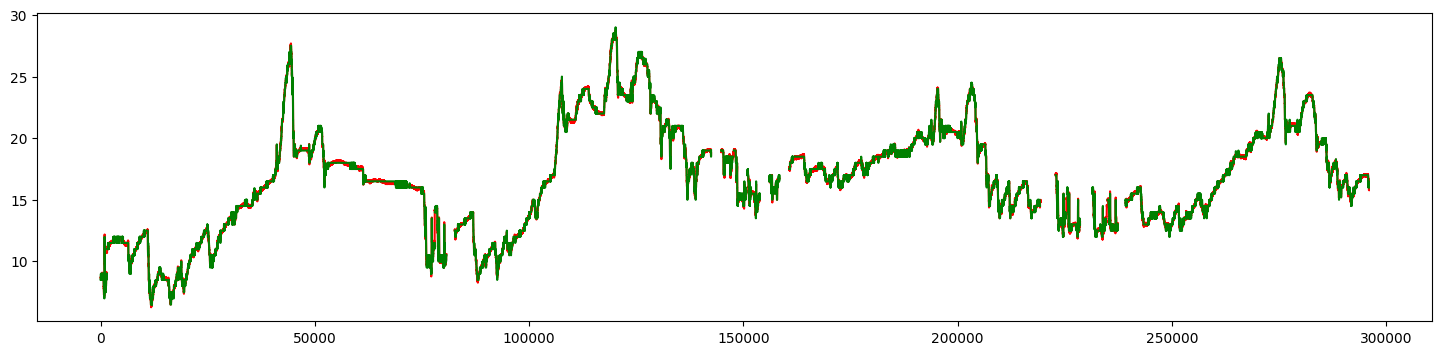

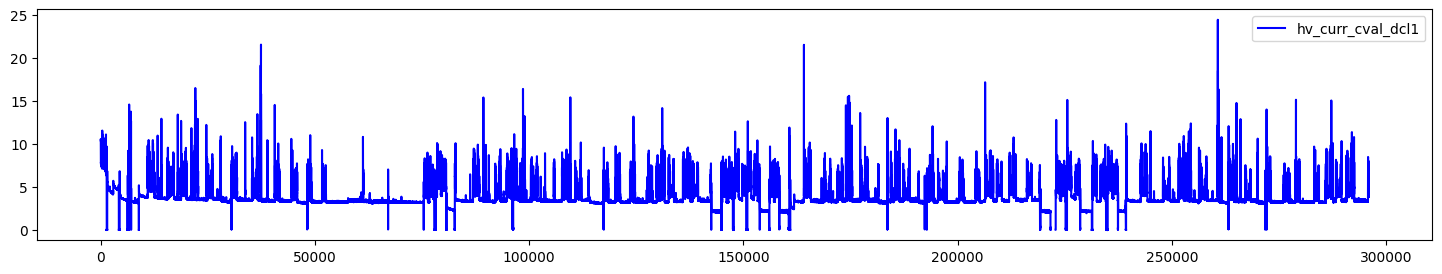

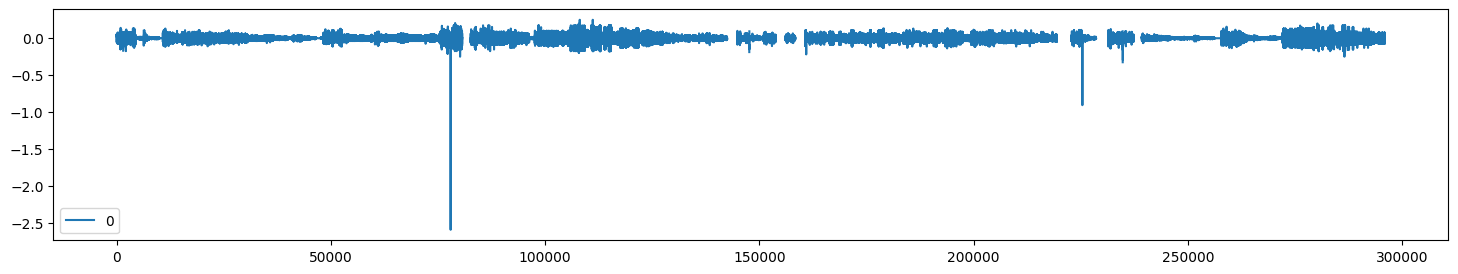

In [990]:
sample = random.choice(trips)
#sample = 'v_id983V10_trip13_2.parquet'
print(sample)
df = pd.read_parquet(Path(DATA_PATH, "processed", sample), engine='fastparquet')
_ = df["airtempoutsd_cval_cpc"].plot(figsize=(18, 4), subplots=True, color='r')
_ = df['ambtemp_cval_pt'].plot(figsize=(18, 3), subplots=True, color='g')
_ = pd.DataFrame(df["hv_curr_cval_dcl1"]).plot(figsize=(18, 3), subplots=True, color='b')

_ = pd.DataFrame(df["airtempoutsd_cval_cpc"] - df["airtempoutsd_cval_sca"]).plot(figsize=(18, 3), subplots=True)
#print((df['lv_conv_dc_momvolt_cval_dcl1'] * df['lv_convcurr_cval_dcl1'] * 1e-3).mean())
print((df["hv_bat_intres_cval_bms1"]).mean())

In [953]:
df["hv_bat_dc_momvolt_cval_bms1"].isna().all()

False

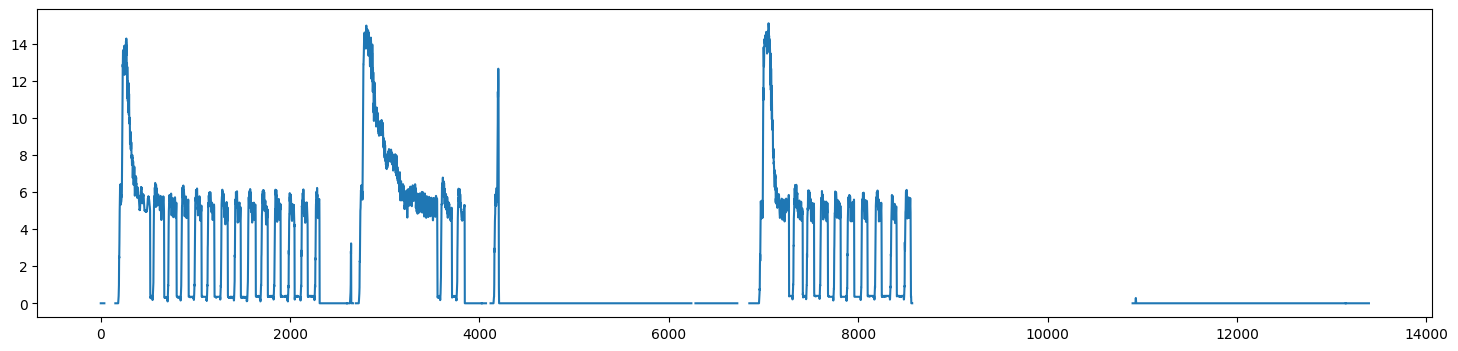

In [94]:
sample = random.choice(info['files'])
df = pd.read_parquet(Path(DATA_PATH, "processed", sample), engine='fastparquet')
#_ = df['actdrvtrnpwrprc_cval'].plot(figsize=(18, 4), subplots=True, color='r')
_ = df['epto_pwr_cval'].plot(figsize=(18, 4), subplots=True)

In [994]:
collected_files = set()
collected_signals = []

for column, info in nan_columns_files.items():
    if info['count'] < 140:
        for file_name in info['files']:
            collected_files.add(file_name)
    else:
        collected_signals.append(column)

collected_files =[x for x in collected_files if x not in short_trips]
print(f"Collected parquet files: {len(collected_files)}")
for file in collected_files:
    print(file)

print(f"Collected signals: {len(collected_signals)}")
for signal in collected_signals:
    print(signal)

Collected parquet files: 163
v_id983V10_trip2.parquet
v_id983V16_trip188.parquet
v_id983V16_trip197.parquet
v_id983V10_trip24.parquet
v_id983V2_trip36_2.parquet
v_id983V10_trip48.parquet
v_id983V17_trip5.parquet
v_id983V19_trip2_2.parquet
v_id983V2_trip12.parquet
v_id983V2_trip5.parquet
v_id983V16_trip3.parquet
v_id983V13_trip5.parquet
v_id983V19_trip1.parquet
v_id983V11_trip14_2.parquet
v_id983V11_trip15.parquet
v_id983V10_trip8.parquet
v_id983V2_trip17.parquet
v_id983V16_trip183.parquet
v_id983V10_trip44.parquet
v_id983V2_trip23.parquet
v_id983V13_trip4.parquet
v_id983V10_trip13.parquet
v_id983V19_trip4.parquet
v_id983V16_trip190.parquet
v_id983V2_trip38.parquet
v_id983V16_trip197_2.parquet
v_id983V16_trip184_2.parquet
v_id983V16_trip187.parquet
v_id983V16_trip196.parquet
v_id983V16_trip191.parquet
v_id983V10_trip21.parquet
v_id983V10_trip38.parquet
v_id983V2_trip15.parquet
v_id983V13_trip276_2.parquet
v_id983V2_trip30.parquet
v_id983V17_trip6.parquet
v_id983V1_trip11.parquet
v_id983

In [ ]:
# Extract mean velocity from each file
mean_velocities = []
dist = []
for file in files:
    df = pd.read_parquet(file, columns = ['vehspd_cval_cpc',"hirestotalvehdist_cval_icuc"], engine='fastparquet')
    mean_velocity = df['vehspd_cval_cpc'].mean()
    d_dist = df["hirestotalvehdist_cval_icuc"].max() - df["hirestotalvehdist_cval_icuc"].min()
    dist.append(d_dist)
    mean_velocities.append(mean_velocity)

# Plot histogram
plt.figure(figsize=(12, 4))
plt.hist(dist, bins=30, edgecolor='black')
plt.xlabel('Driven Distance')
plt.ylabel('Count')
plt.title('Histogram of Distances')
plt.grid(True)
plt.show()


dist = [d for d in dist if d <= 1000]
plt.figure(figsize=(12, 4))
plt.hist(dist, bins=30, edgecolor='black')
plt.xlabel('Driven Distance [km]')
plt.ylabel('Count')
plt.title('Histogram of Distances')
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase tick numbers size
plt.show()